# <a> Get the dataset
---


In [ ]:
!wget https://wufs.wustl.edu/SpaceApps/data/space_apps_2024_seismic_detection.zip

--2024-10-05 00:36:31--  https://wufs.wustl.edu/SpaceApps/data/space_apps_2024_seismic_detection.zip
Resolving wufs.wustl.edu (wufs.wustl.edu)... 128.252.144.157
Connecting to wufs.wustl.edu (wufs.wustl.edu)|128.252.144.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2259607647 (2.1G) [application/x-zip-compressed]
Saving to: ‘space_apps_2024_seismic_detection.zip’

space_apps_2024_sei 100%[===================>]   2.10G  1.22MB/s    in 30m 27s 

2024-10-05 01:06:59 (1.18 MB/s) - ‘space_apps_2024_seismic_detection.zip’ saved [2259607647/2259607647]



In [ ]:
!unzip space_apps_2024_seismic_detection.zip

# <a> Installing the req. Libraries
___

In [ ]:
!pip install statsmodels obspy

# <a> Imports
---

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import obspy
from obspy import read
import glob


# <a> Pre-process the Seismic Data
---

In [ ]:
# Define the paths to your CSV files (lunar and Mars seismic event catalogs)
file_path_lunar = '/content/space_apps_2024_seismic_detection/data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
file_path_Mars = '/content/space_apps_2024_seismic_detection/data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv'

# Read the CSV files into pandas DataFrames
df1 = pd.read_csv(file_path_lunar)
df2 = pd.read_csv(file_path_Mars)

# List of directories containing training seismic data in MSEED format
data_folders = ['/content/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA',
                '/content/space_apps_2024_seismic_detection/data/mars/training/data']

# Load seismic data and match with arrival times for each file independently
seismic_data = []
arrival_times = []

# Iterate through both folders and load matching seismic files
for folder in data_folders:
    for index, row in df1.iterrows():  # Using df1 for lunar data, df2 for Mars (handled separately)
        file_name = row['filename']
        arrival_time = row['time_rel(sec)']

        # Check if file exists in the current folder
        file_path = os.path.join(folder, file_name + '.mseed')
        if os.path.exists(file_path):
            # Load seismic file using obspy
            st = obspy.read(file_path)

            # Store the loaded data and arrival time separately for each file
            seismic_data.append(st)
            arrival_times.append(arrival_time)

# Function to create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# <a> Buildnig and Training the LSTM model

In [ ]:
# Function to build and train LSTM model
def train_lstm_model(X, y):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=3, batch_size=64, verbose=0)

    return model

# Training Phase: Train the model on the first 10 seismic datasets
train_data = []
for i in range(min(10, len(seismic_data))):  # Use only the first 10 files for training
    # Extract seismic waveform data as a numpy array
    data = np.array([tr.data for tr in seismic_data[i]], dtype=np.float32).reshape(-1, 1)

    # Normalize the data
    data = (data - np.mean(data)) / np.std(data)

    # Append the normalized data to the training set
    train_data.append(data)

# Concatenate all the training data
train_data = np.vstack(train_data)

# Create sequences for LSTM
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Reshape for LSTM

# Train the LSTM model on the combined data from the first 5 files
lstm_model = train_lstm_model(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# <a> generating the output of the test data of Mars

2249/2249 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


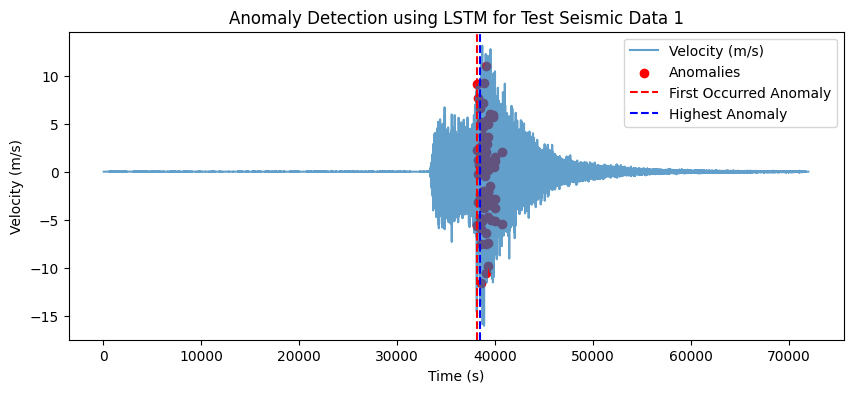

2249/2249 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


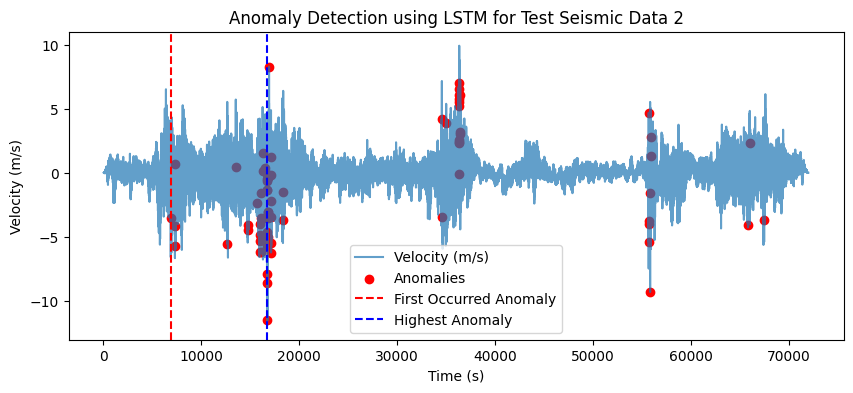

2249/2249 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


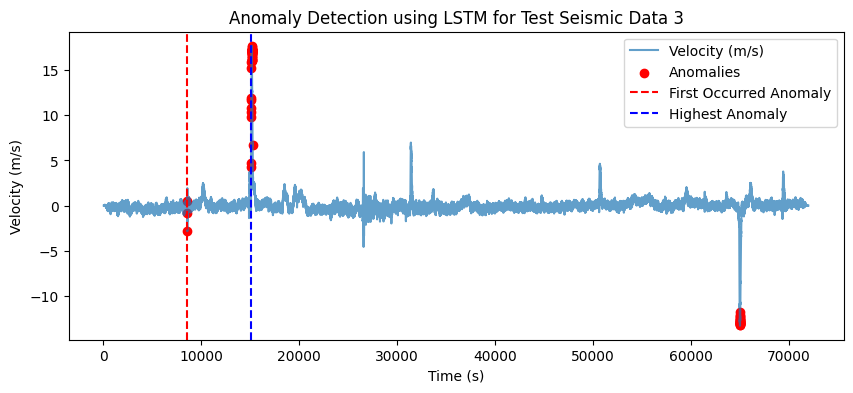

2249/2249 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


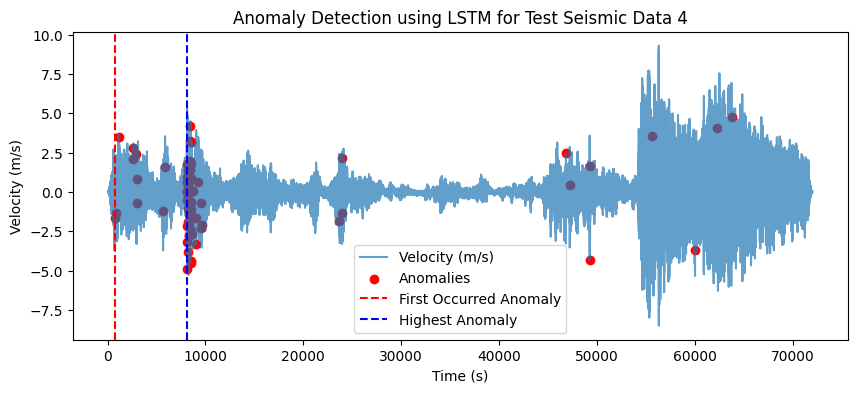

2249/2249 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


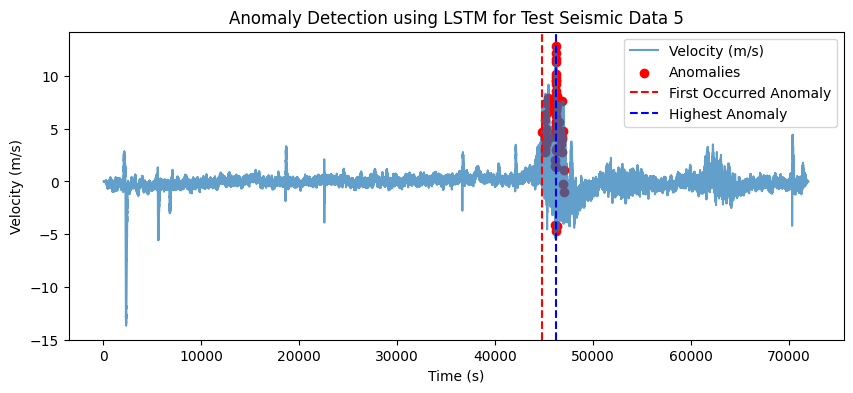

2249/2249 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


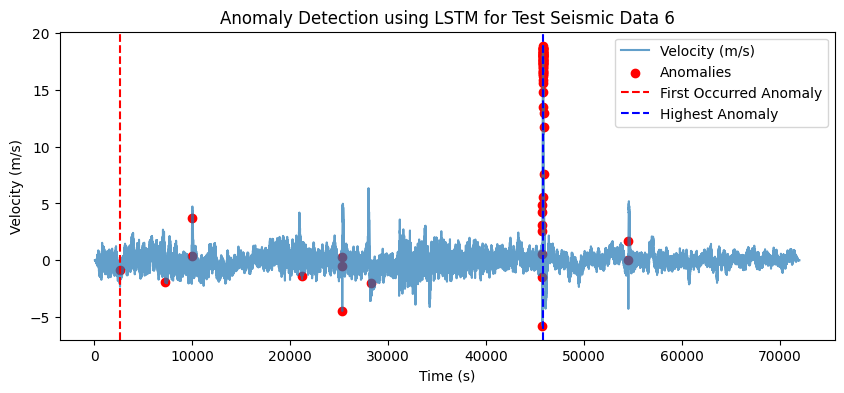

2249/2249 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


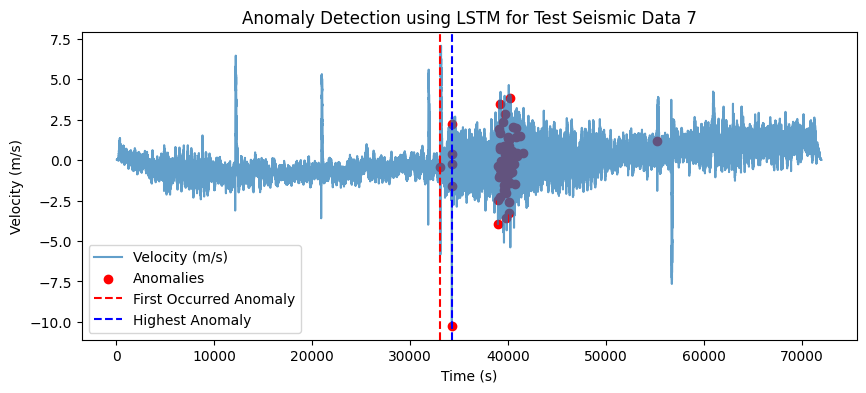

2249/2249 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


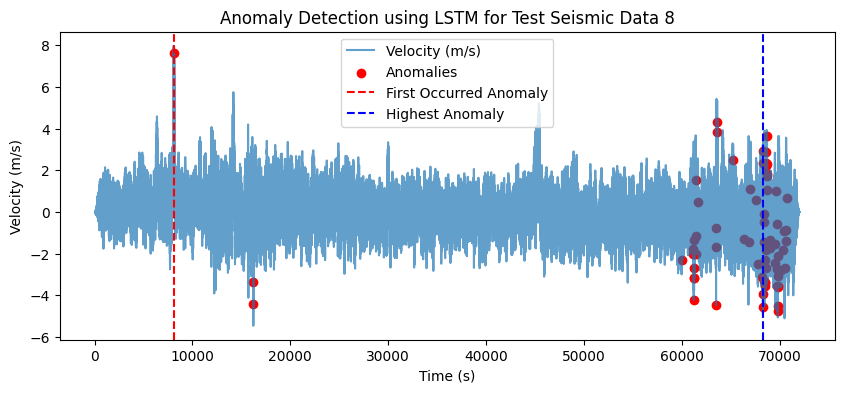

2249/2249 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


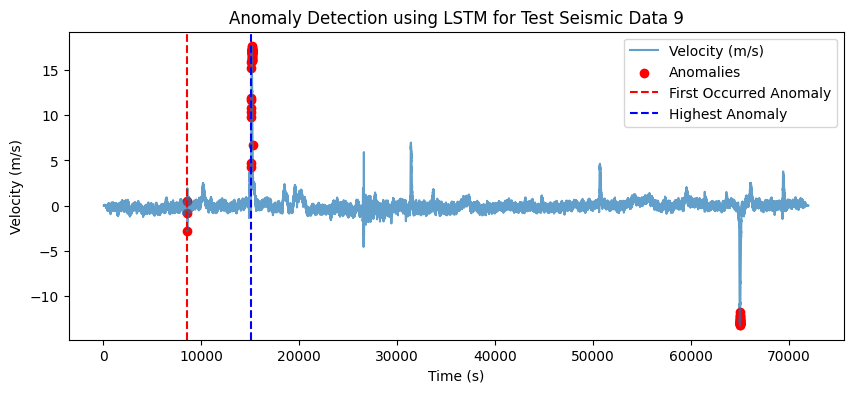

                                           file_name  \
0  1 Trace(s) in Stream:\nXB.ELYSE.02.BHV | 2022-...   
1  1 Trace(s) in Stream:\nXB.ELYSE.02.BHV | 2021-...   
2  1 Trace(s) in Stream:\nXB.ELYSE.02.BHV | 2019-...   
3  1 Trace(s) in Stream:\nXB.ELYSE.02.BHV | 2021-...   
4  1 Trace(s) in Stream:\nXB.ELYSE.02.BHV | 2019-...   
5  1 Trace(s) in Stream:\nXB.ELYSE.02.BHV | 2019-...   
6  1 Trace(s) in Stream:\nXB.ELYSE.02.BHV | 2021-...   
7  1 Trace(s) in Stream:\nXB.ELYSE.02.BHV | 2022-...   
8  1 Trace(s) in Stream:\nXB.ELYSE.02.BHV | 2019-...   

   time_of_highest_anomaly(sec)  
0                         38520  
1                         16729  
2                         15111  
3                          8132  
4                         46206  
5                         45822  
6                         34260  
7                         68279  
8                         15111  


In [ ]:
# Path to the test data directory
test_data_folder = '/content/space_apps_2024_seismic_detection/data/mars/test/data/'


# Iterate through all subfolders and files within the test data folder
test_seismic_data = []

# Iterate through all files within the test data folder
for file in os.listdir(test_data_folder):
    if file.endswith('.mseed'):
        file_path = os.path.join(test_data_folder, file)

        # Load seismic file using obspy
        st = obspy.read(file_path)

        # Store the loaded data for testing
        test_seismic_data.append(st)


# List to hold results for DataFrame
results_list = []

# Testing Phase: Use the trained model to predict on the test data
for i, st in enumerate(test_seismic_data):  # Use the test data from the subfolders
    # Extract seismic waveform data as a numpy array for each test file
    test_data = np.array([tr.data for tr in st], dtype=np.float32).reshape(-1, 1)

    # Normalize the test data
    test_data = (test_data - np.mean(test_data)) / np.std(test_data)

    # Create sequences for test data
    X_test, y_test = create_dataset(test_data, time_step)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # Reshape for LSTM

    # Make predictions on the test data using the trained model
    predicted_test = lstm_model.predict(X_test)

    # Calculate reconstruction error
    reconstruction_error_test = np.abs(predicted_test.flatten() - y_test)

    # Set a threshold for anomaly detection in test data
    threshold_test = np.percentile(reconstruction_error_test, 99.9)
    anomalies_test = reconstruction_error_test > threshold_test

    # Create a DataFrame to hold results for the test file
    results_test_df = pd.DataFrame({
        'time_rel(sec)': np.arange(len(y_test)) + time_step + 1,
        'velocity(m/s)': test_data[time_step + 1:len(predicted_test) + time_step + 1, 0],
        'reconstruction_error': reconstruction_error_test,
        'is_anomaly': anomalies_test
    })


    # Get the first occurred anomaly in the test file

    first_anomaly_test = results_test_df[results_test_df['is_anomaly']].sort_values(by='time_rel(sec)').iloc[0]

    # Get the highest anomaly in the test file (based on reconstruction error)

    highest_anomaly_test = results_test_df[results_test_df['is_anomaly']].sort_values(by='reconstruction_error', ascending=False).iloc[0]

    # Plot the results for the test file
    plt.figure(figsize=(10, 4))
    plt.plot(results_test_df['time_rel(sec)'], results_test_df['velocity(m/s)'], label='Velocity (m/s)', alpha=0.7)
    plt.scatter(results_test_df['time_rel(sec)'][results_test_df['is_anomaly']],
                results_test_df['velocity(m/s)'][results_test_df['is_anomaly']], color='red', label='Anomalies')

    # Mark the first occurred anomaly with a vertical line
    plt.axvline(x=first_anomaly_test['time_rel(sec)'], color='r', linestyle='--', label='First Occurred Anomaly')

    # Mark the highest anomaly with a vertical line
    plt.axvline(x=highest_anomaly_test['time_rel(sec)'], color='b', linestyle='--', label='Highest Anomaly')

    # Customize plot
    plt.title(f'Anomaly Detection using LSTM for Test Seismic Data {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.legend()
    plt.show()

    # Get the file name from the path
    file_name = os.path.basename(test_seismic_data[i].__str__())

    # Append the file name and the time of the highest anomaly to results_list
    results_list.append({
        'file_name': file_name,
        'time_of_highest_anomaly(sec)': highest_anomaly_test['time_rel(sec)']
    })

    # (The rest of your plotting and printing code remains unchanged)

# After processing all test files, create a DataFrame from the results_list
results_df = pd.DataFrame(results_list)

# Save the results DataFrame to a CSV file
results_df.to_csv('anomaly_detection_results.csv', index=False)

# Optionally, display the results DataFrame
print(results_df)


# <a> generating the output of the test data of the moon

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step


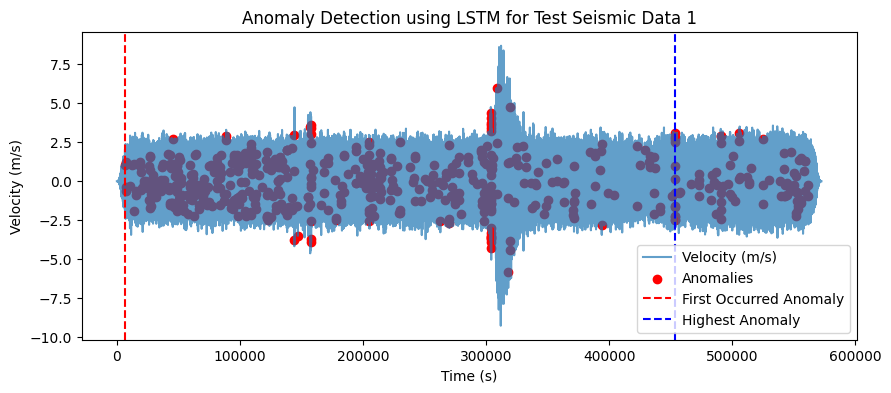

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step


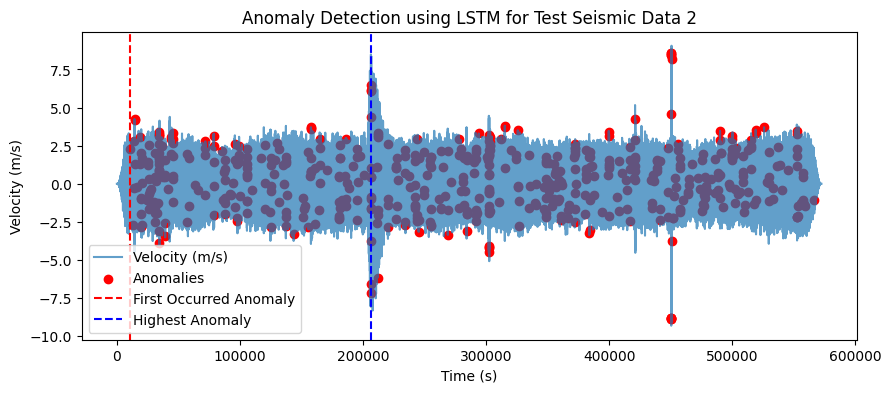

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step


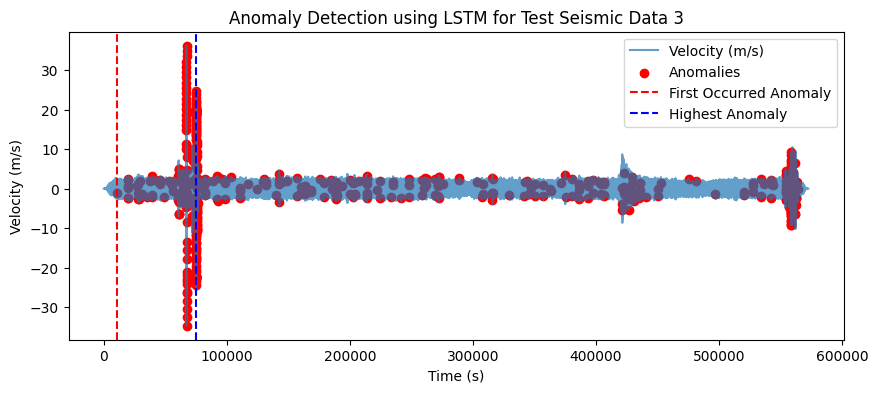

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step


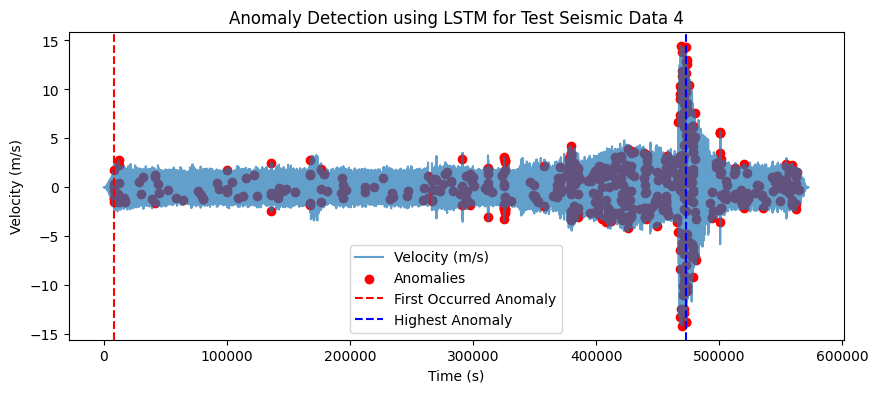

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step


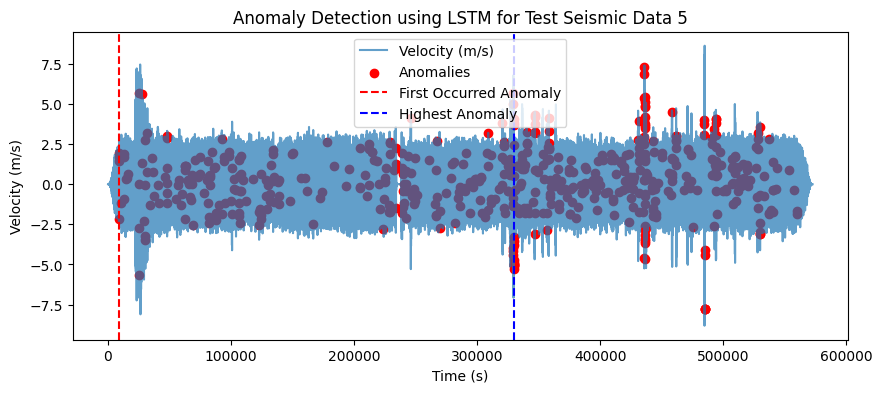

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step


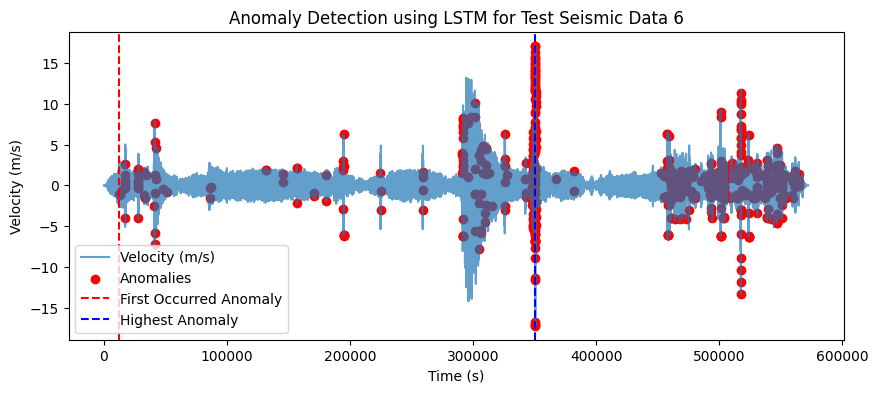

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step


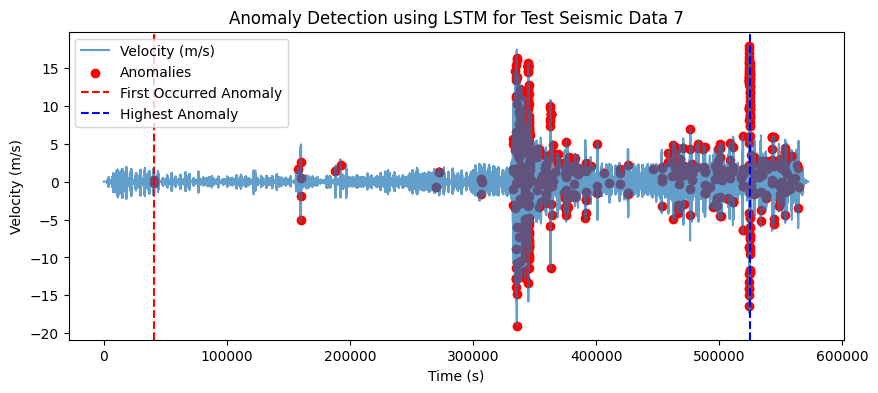

17636/17636 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step


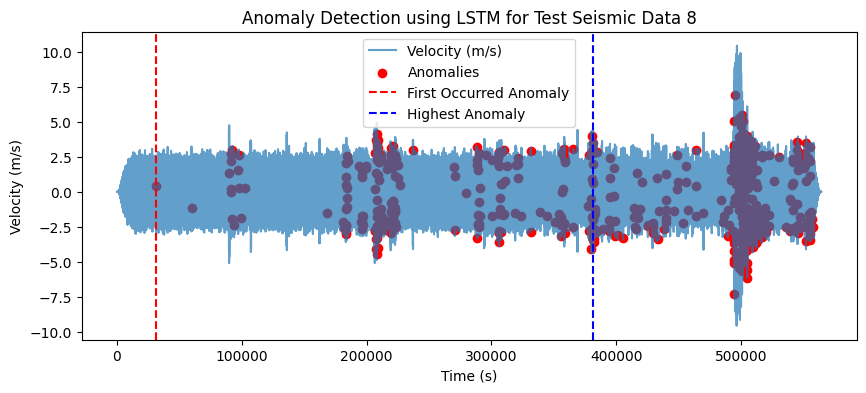

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step


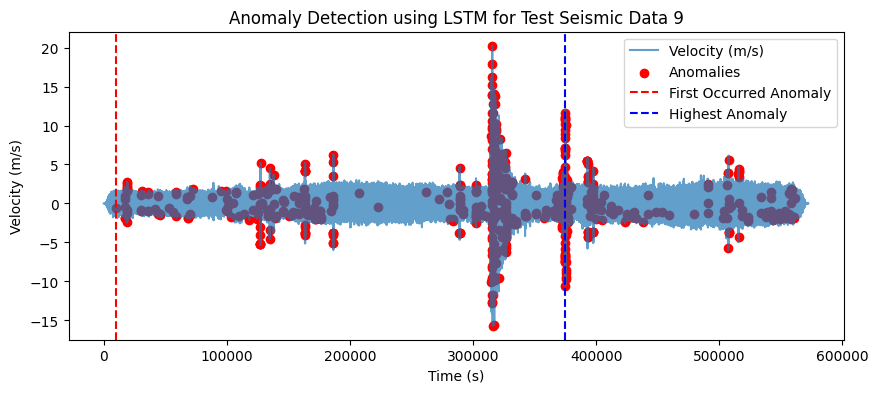

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step


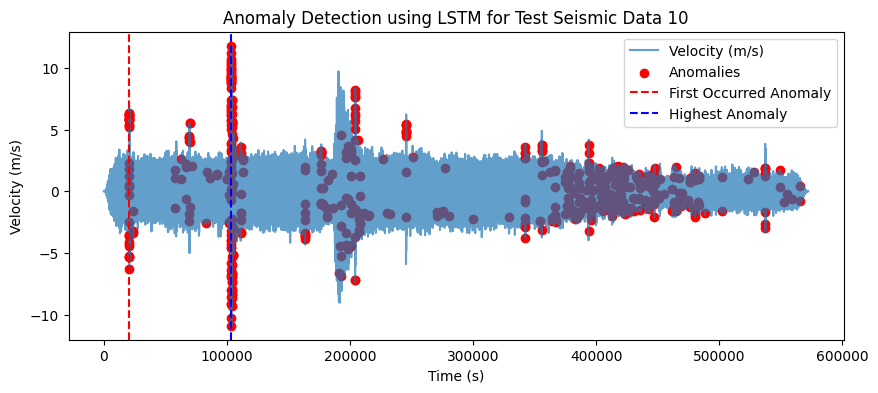

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step


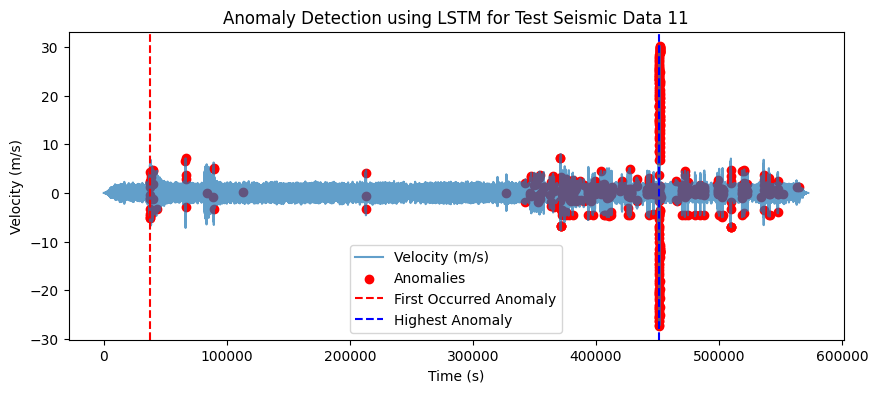

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step


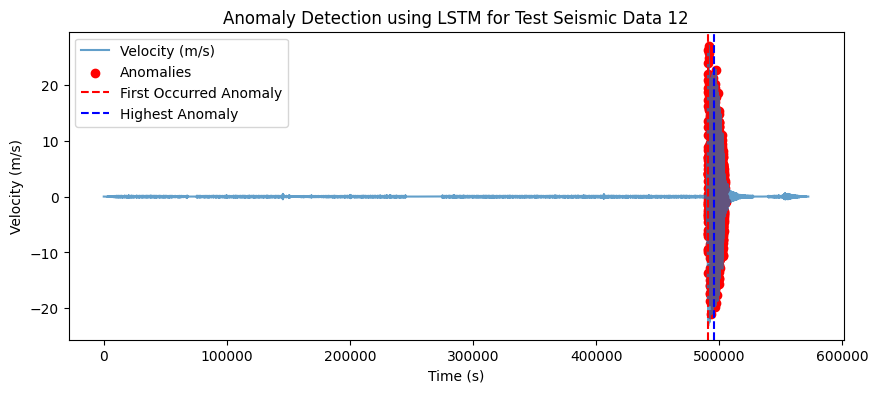

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step


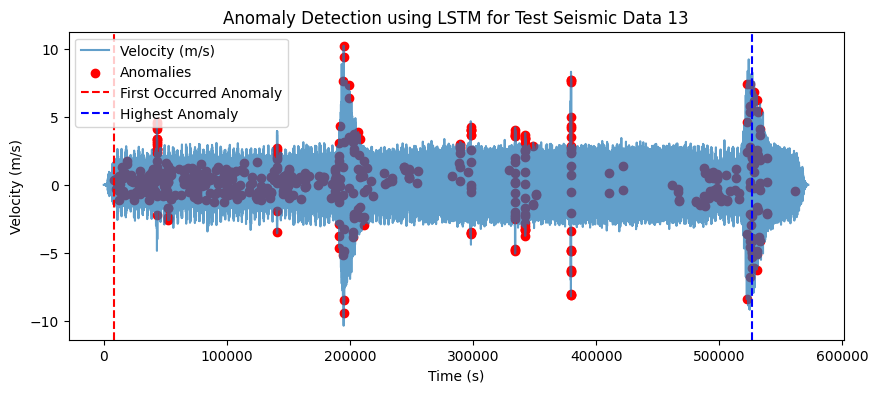

14109/14109 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step


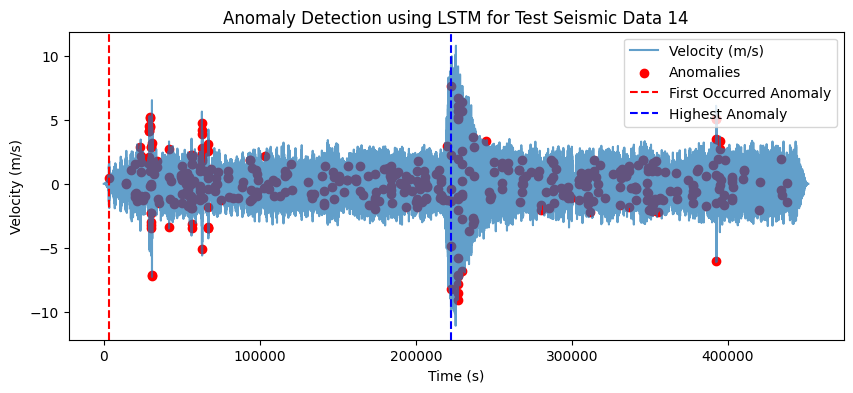

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step


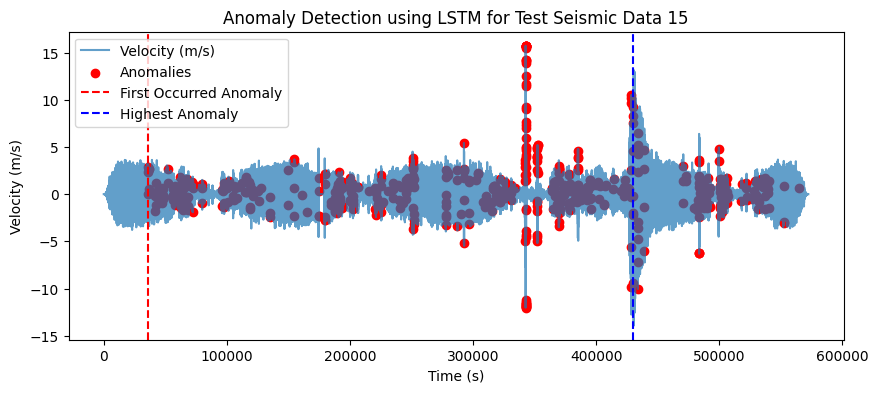

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step


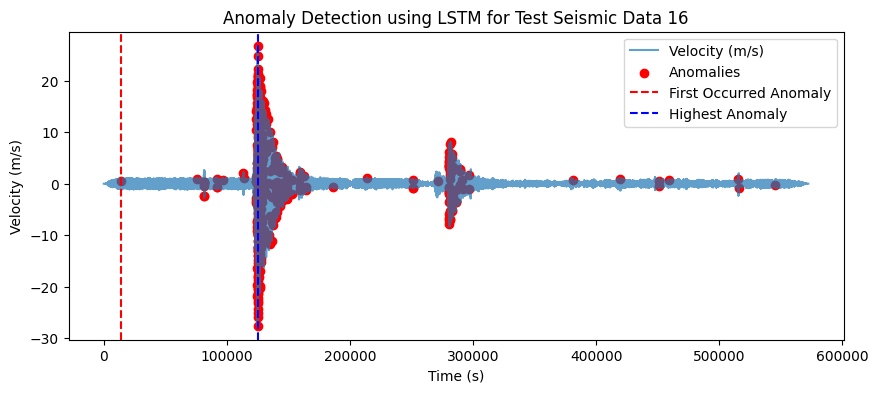

16965/16965 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step


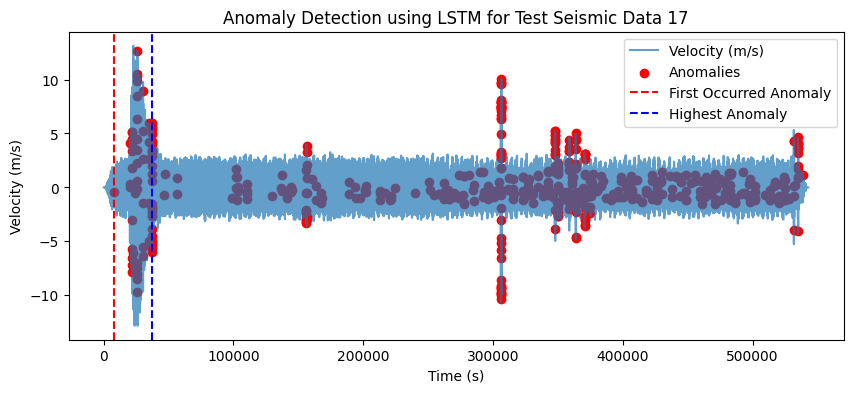

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step


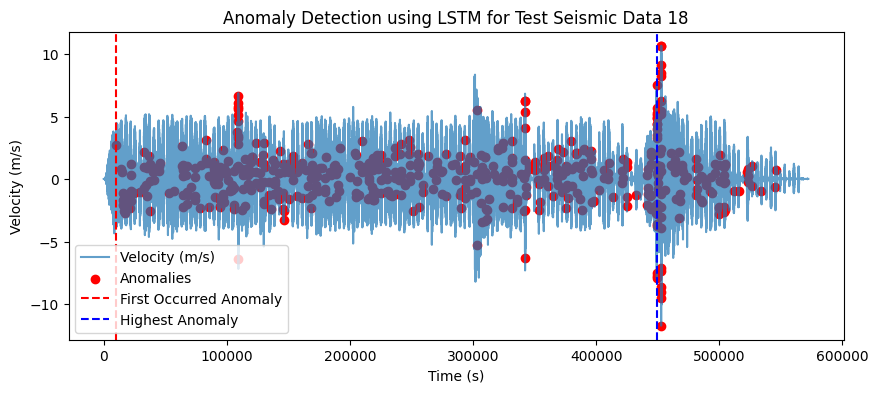

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step


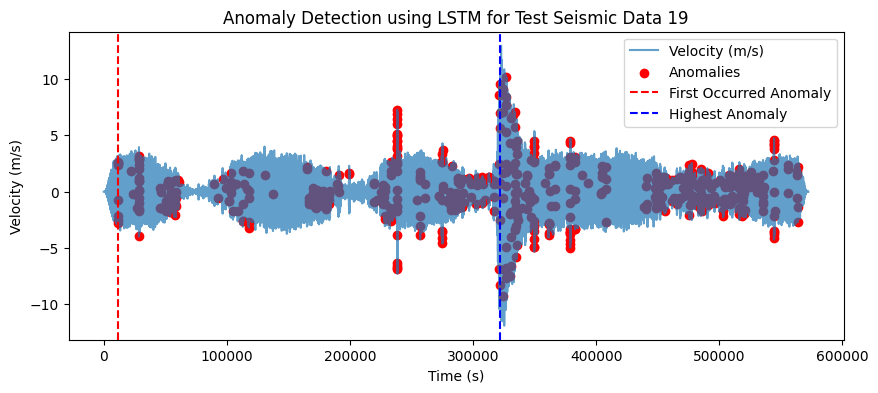

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step


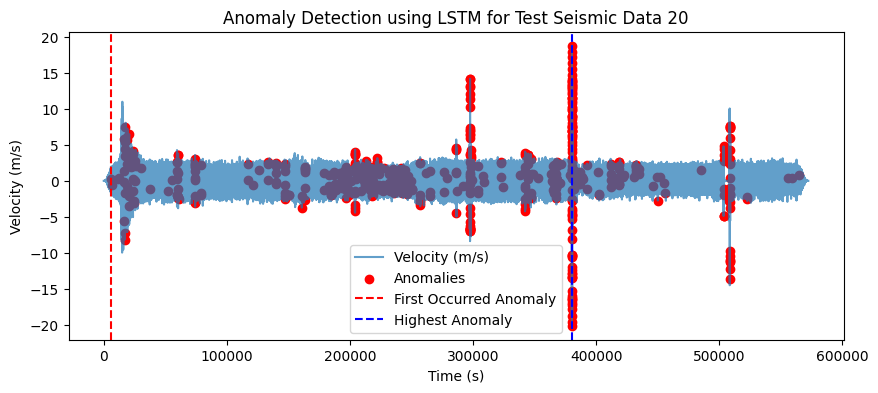

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step


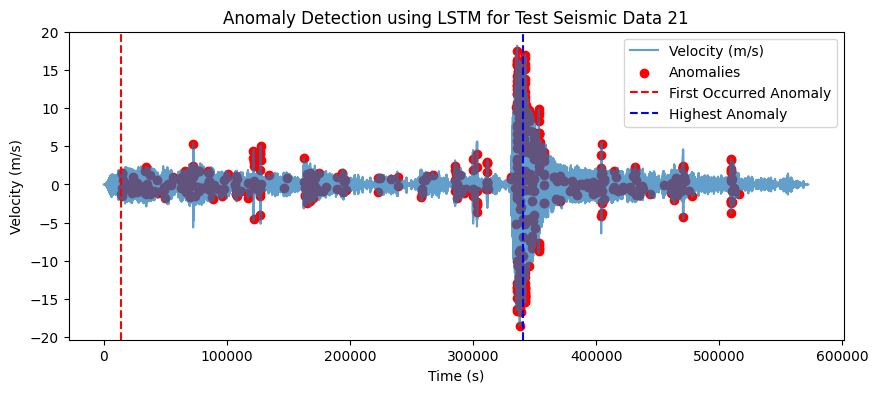

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step


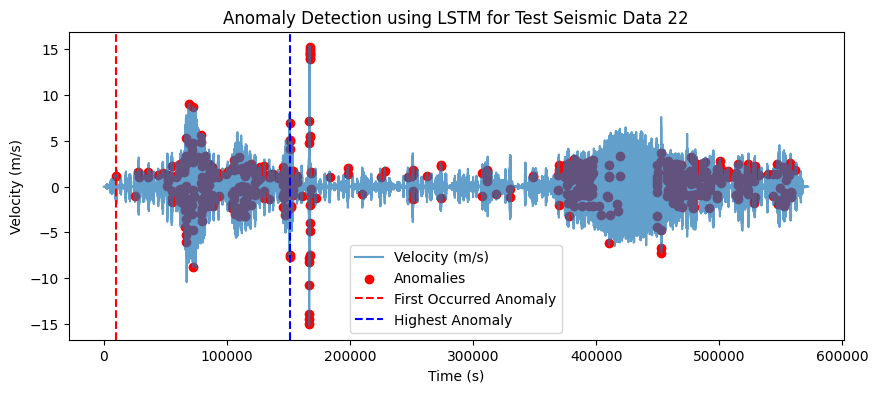

14915/14915 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step


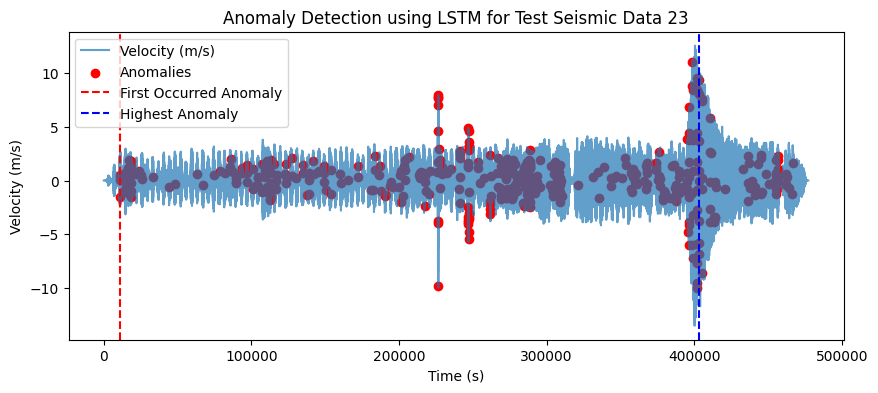

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step


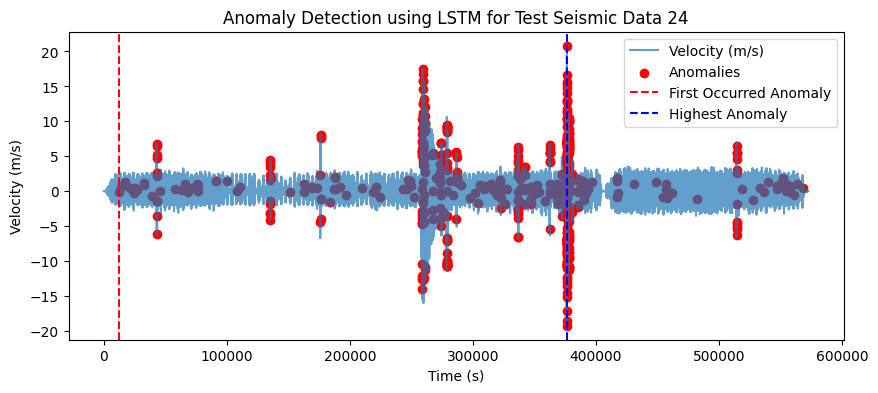

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step


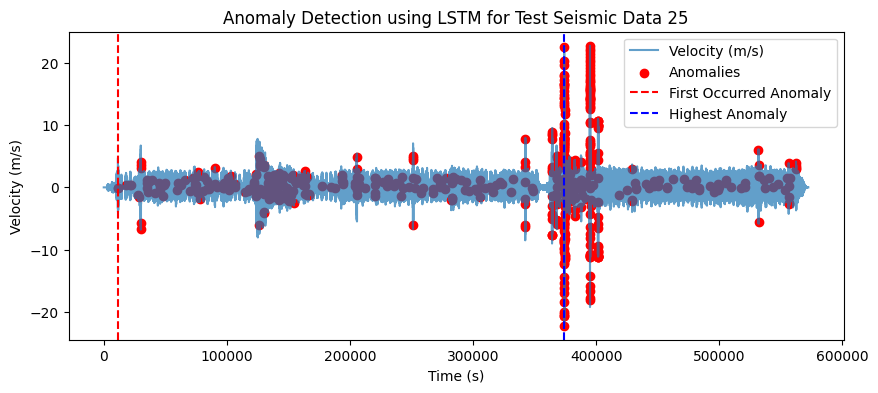

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step


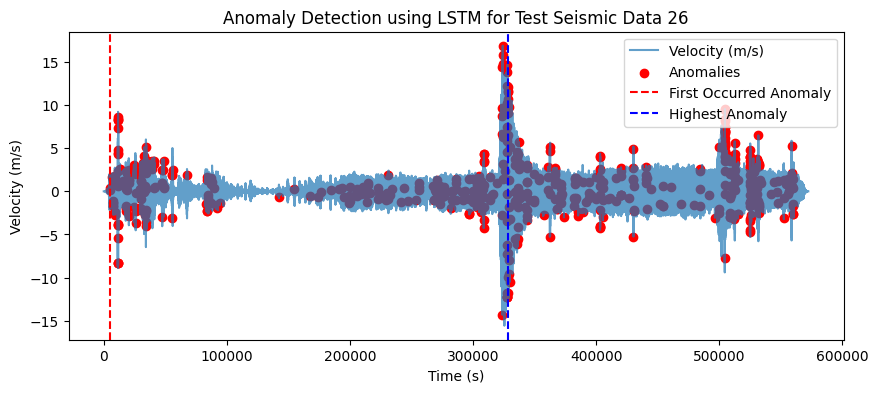

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step


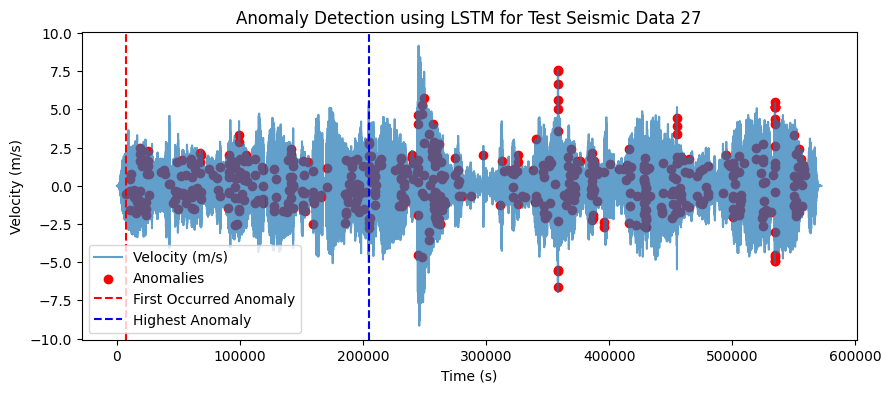

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step


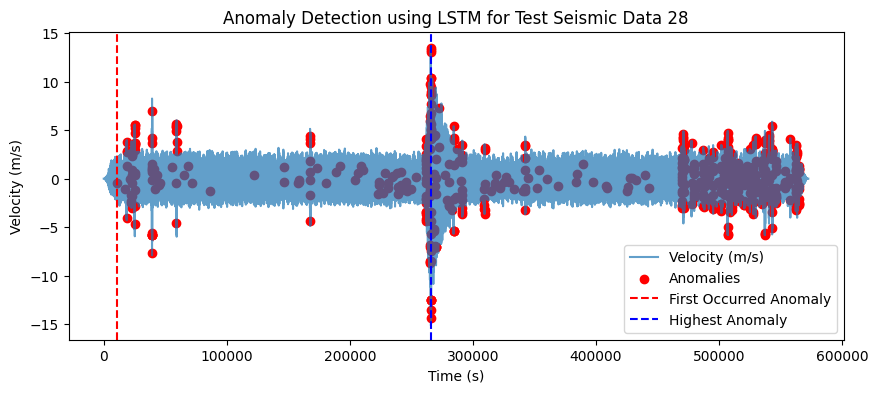

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step


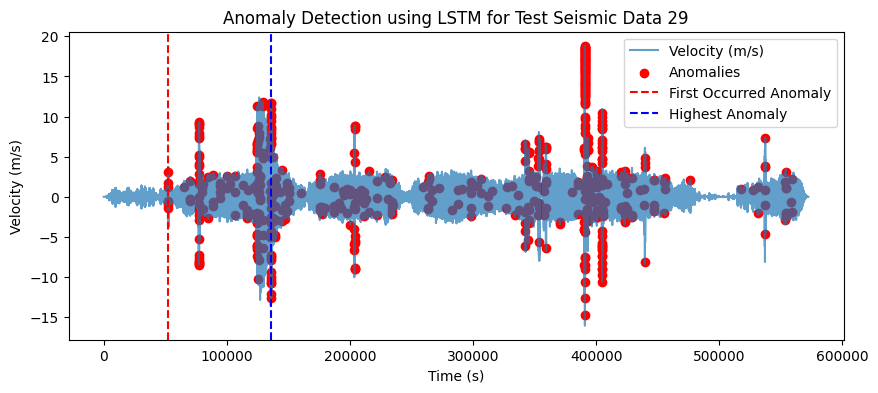

17885/17885 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step


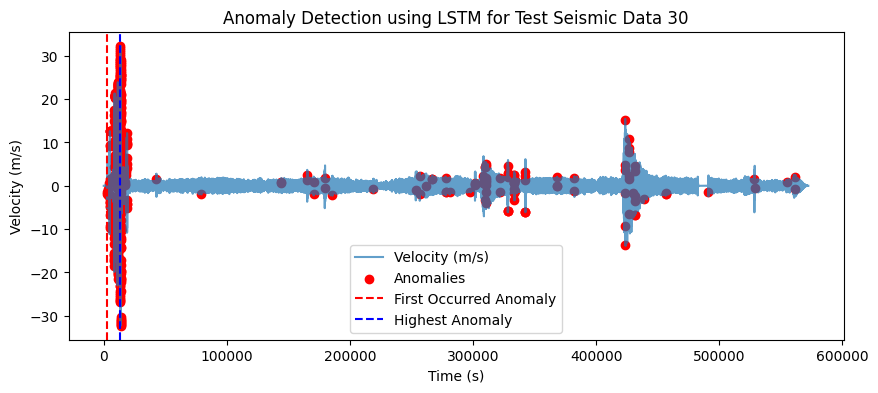

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step


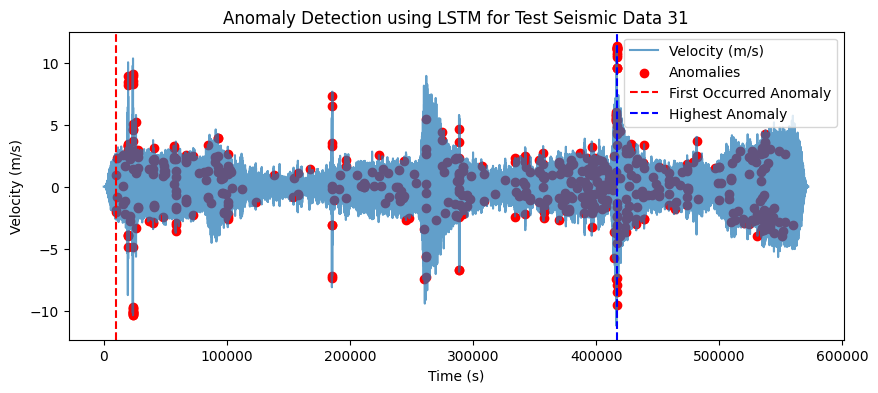

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step


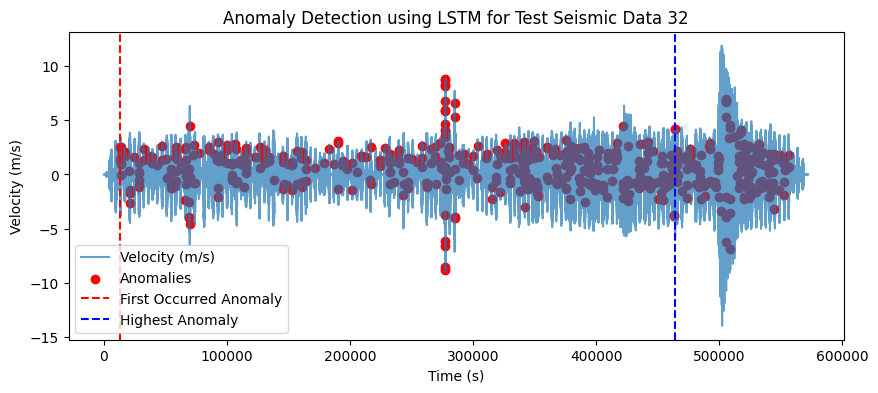

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step


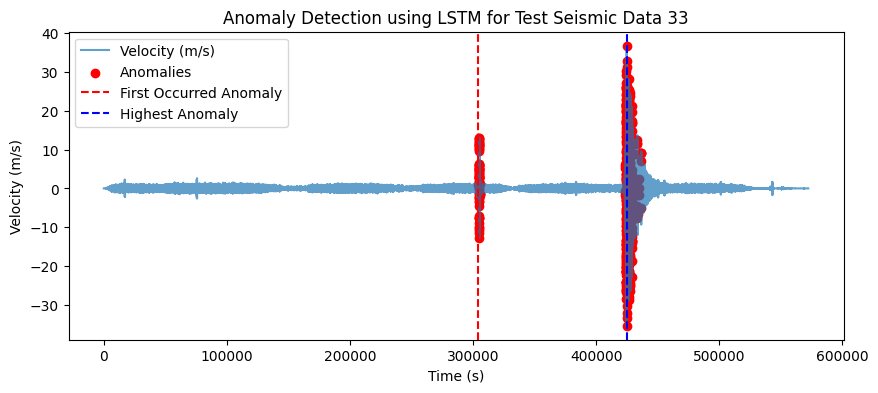

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step


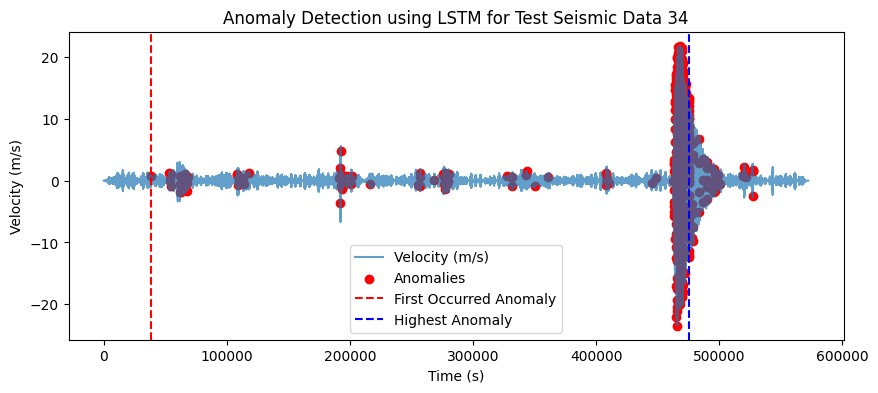

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step


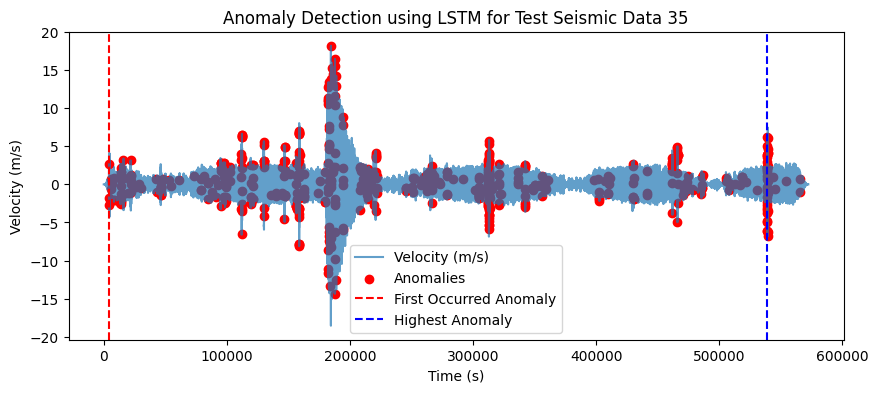

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


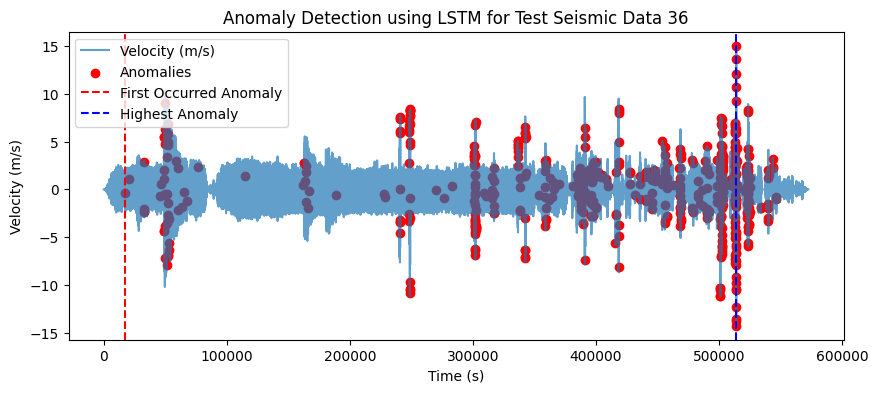

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step


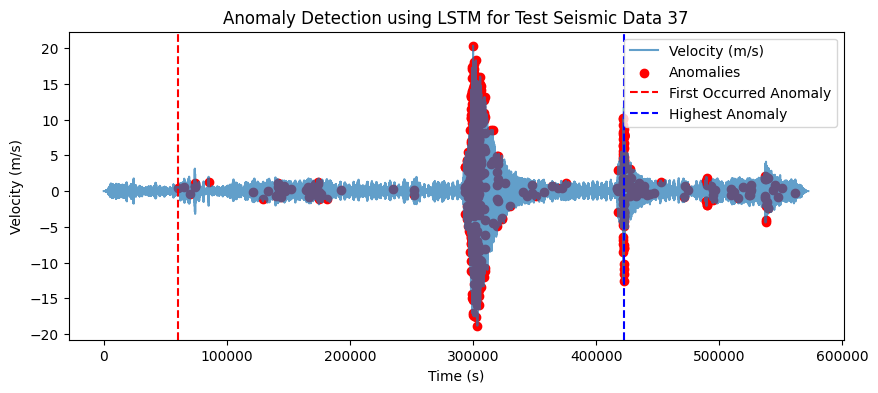

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


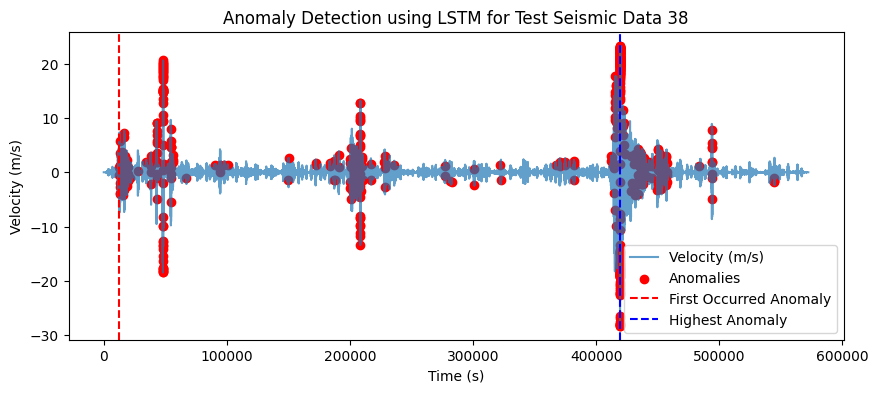

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


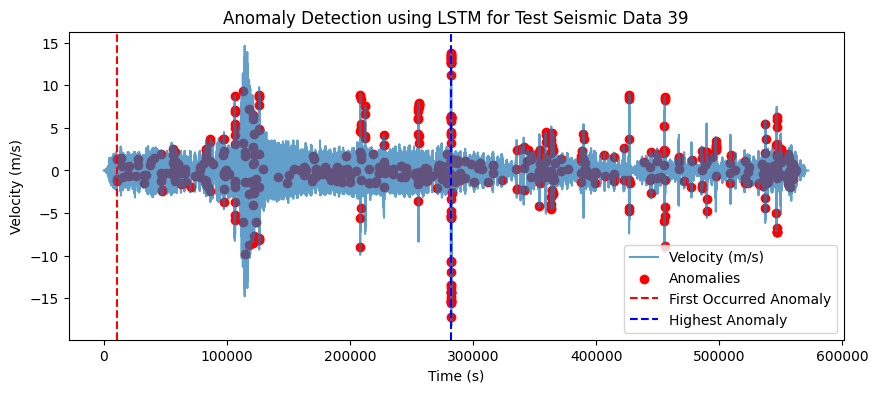

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


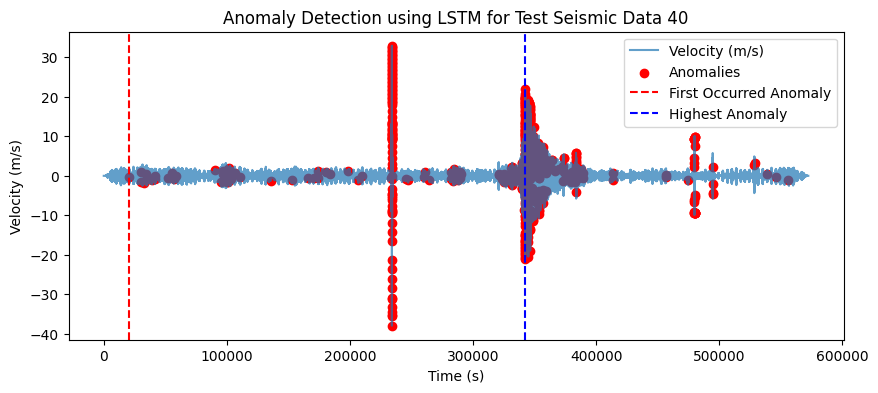

8324/8324 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step


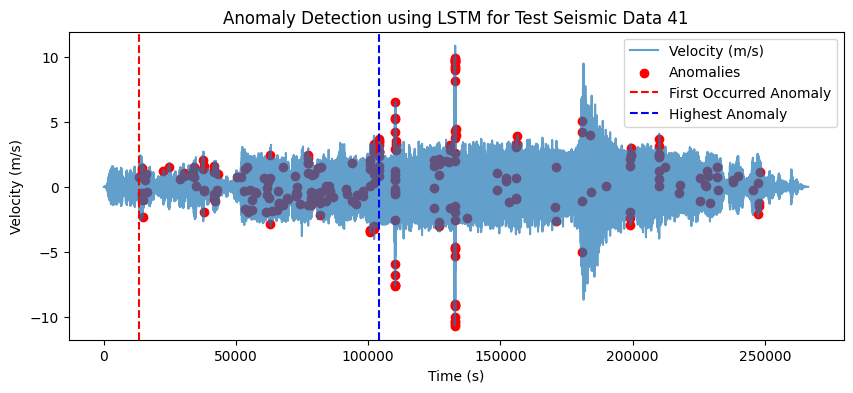

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


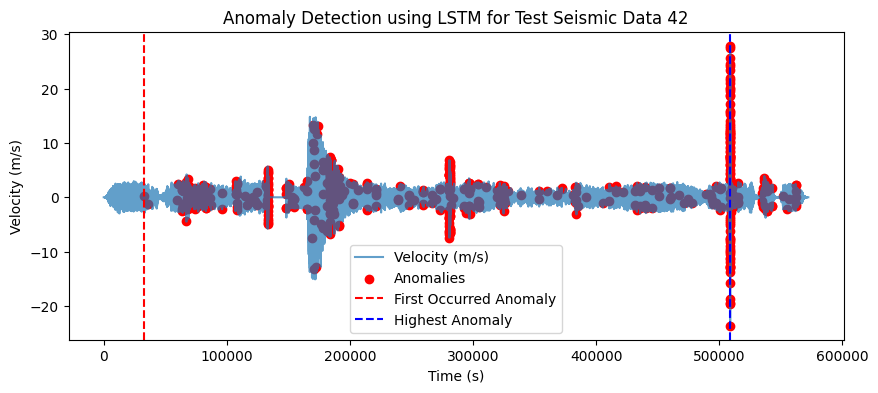

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


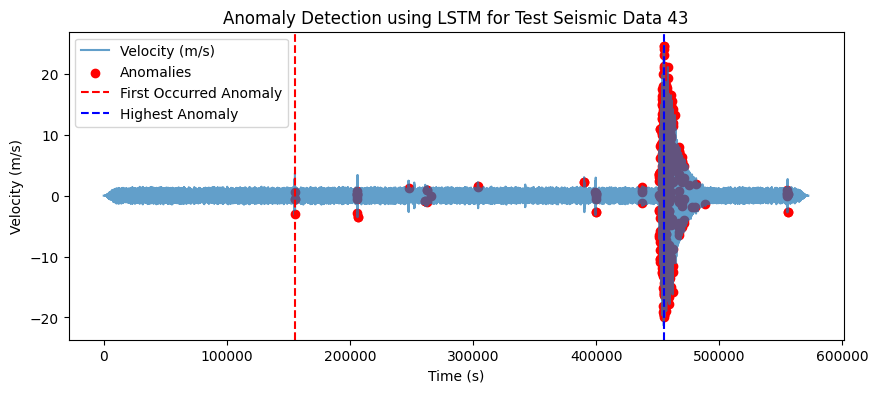

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


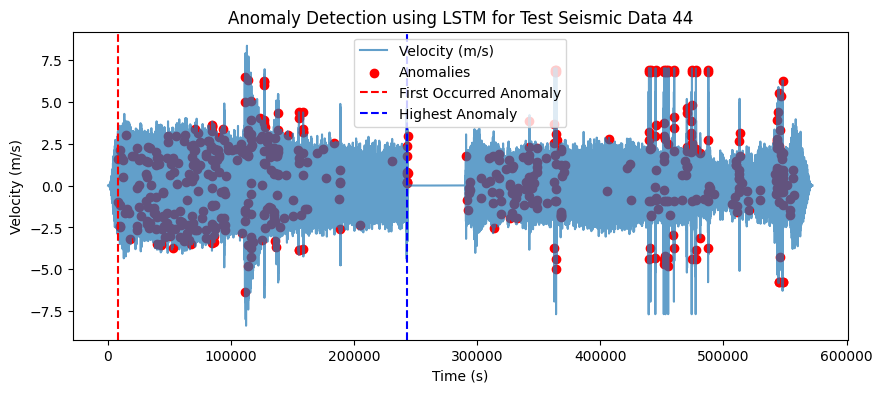

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


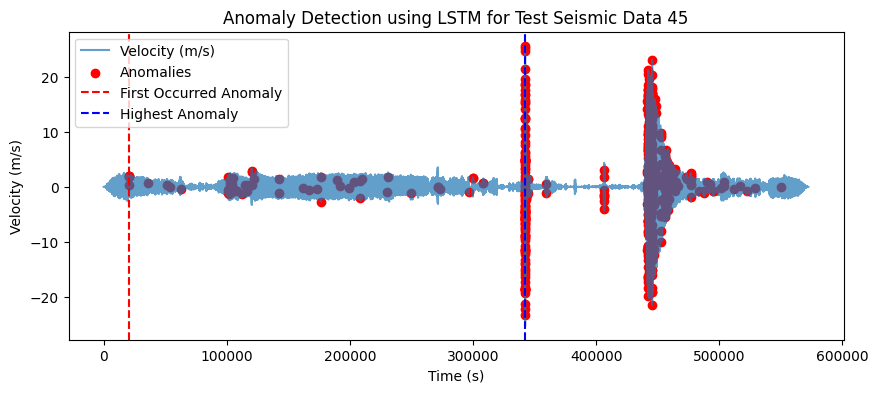

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


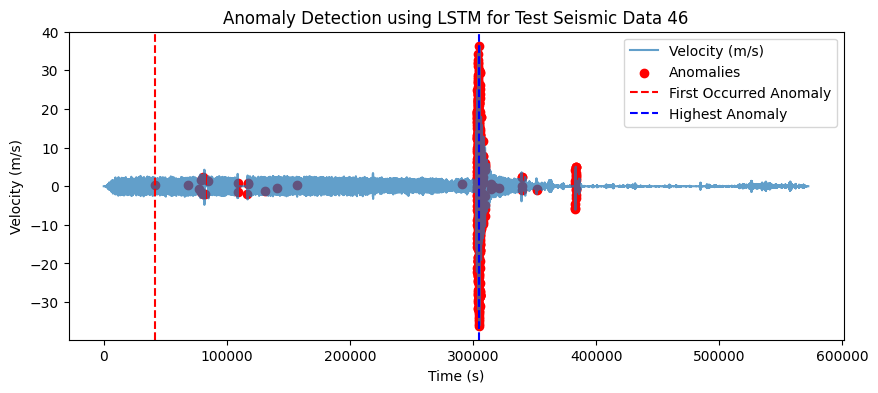

17786/17786 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


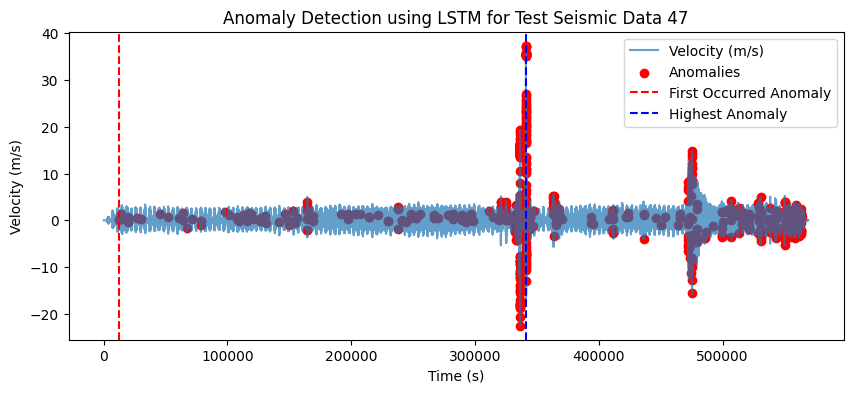

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


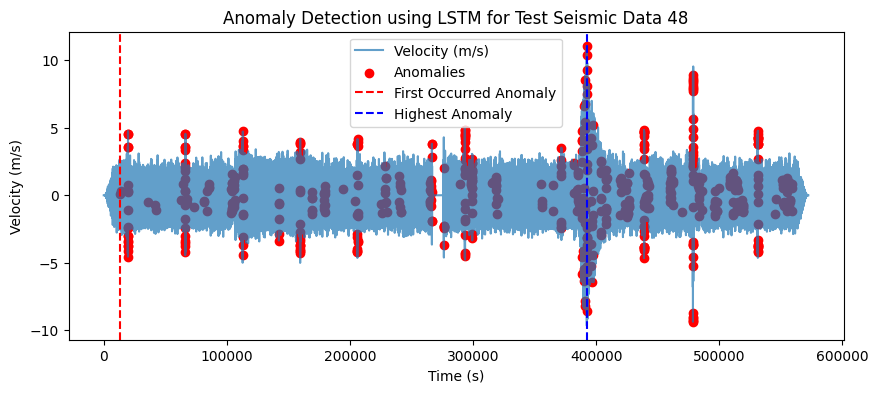

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


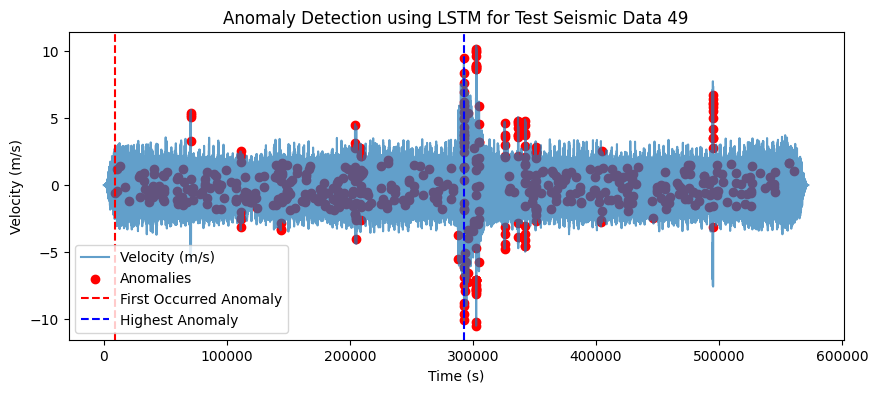

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


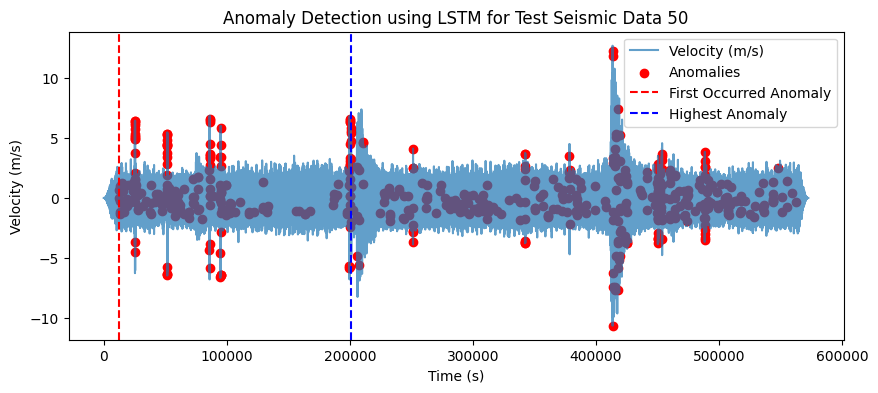

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


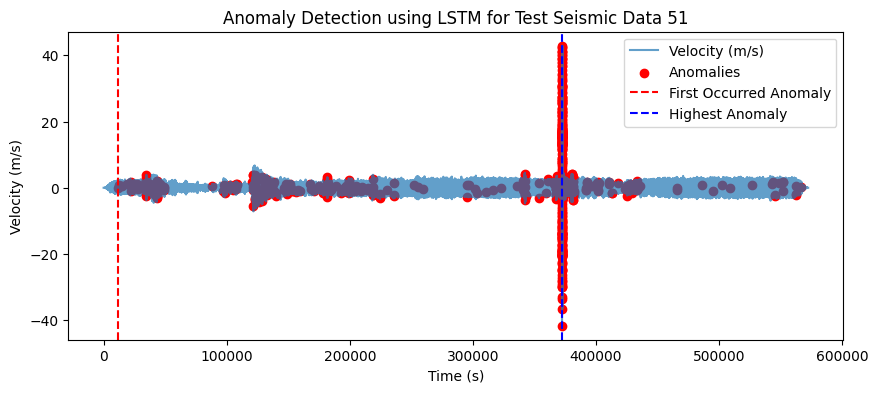

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


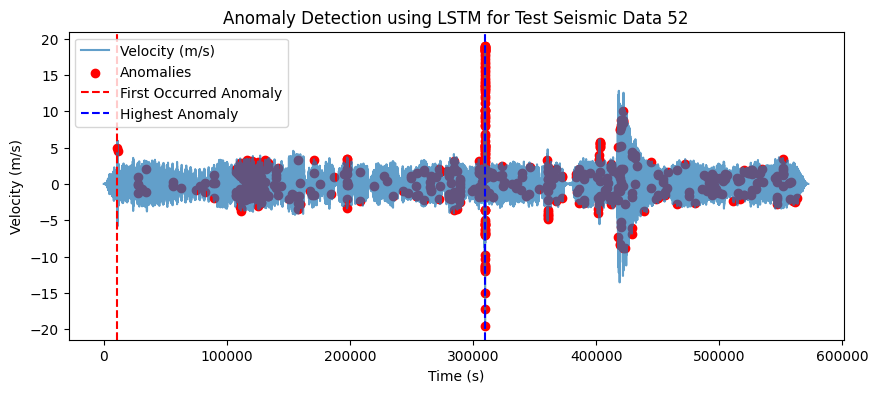

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step


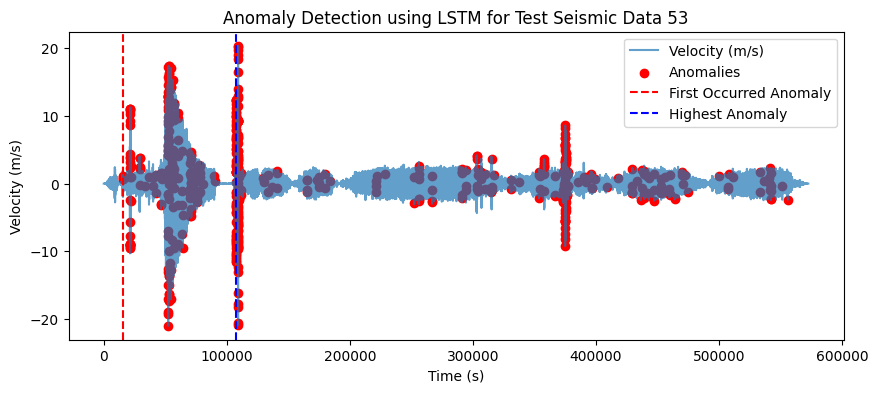

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


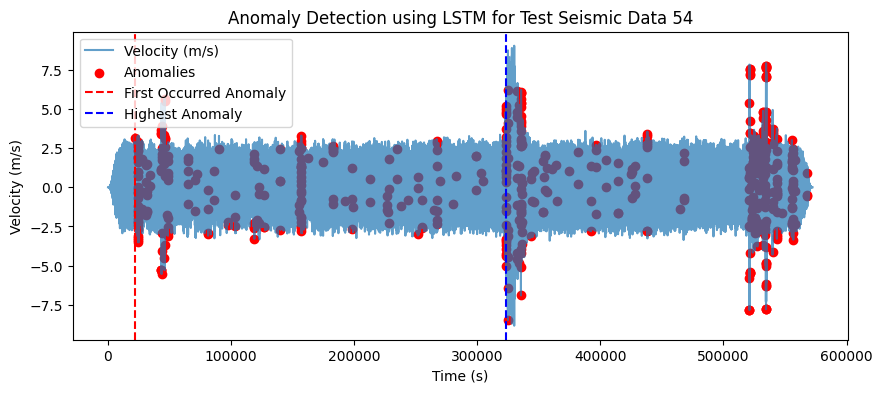

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


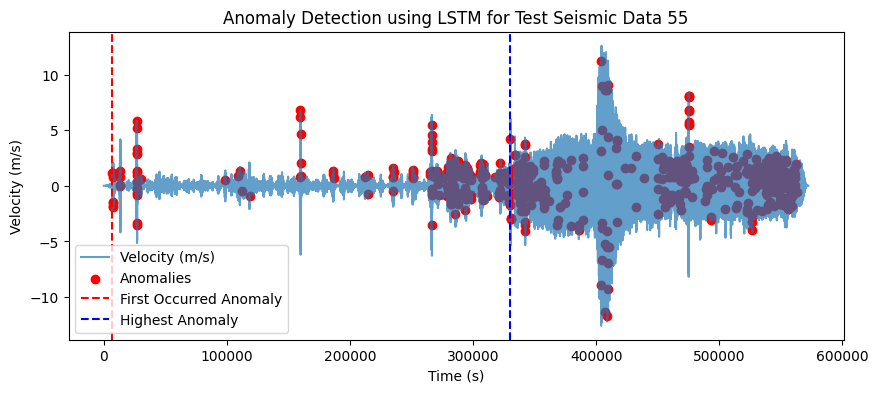

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step


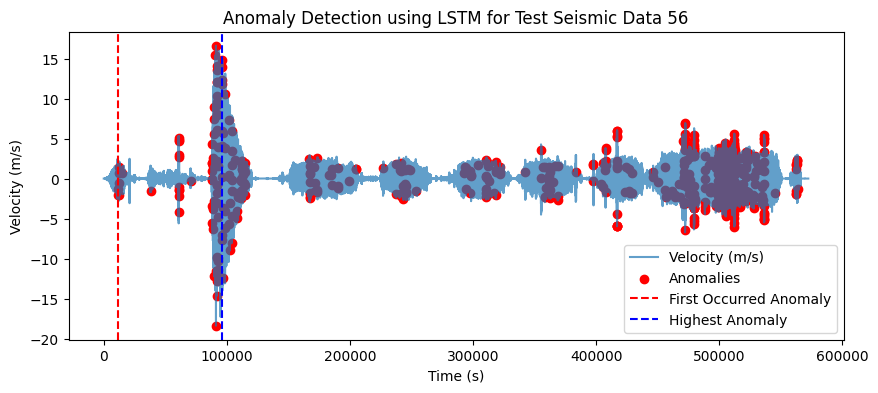

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step


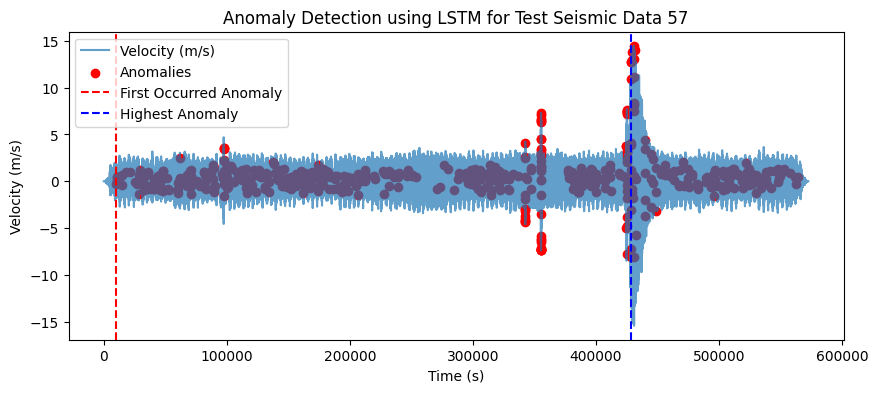

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step


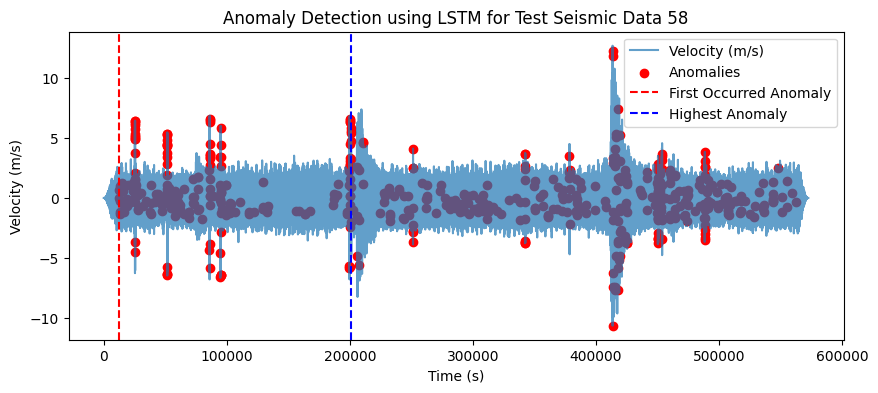

17883/17883 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step


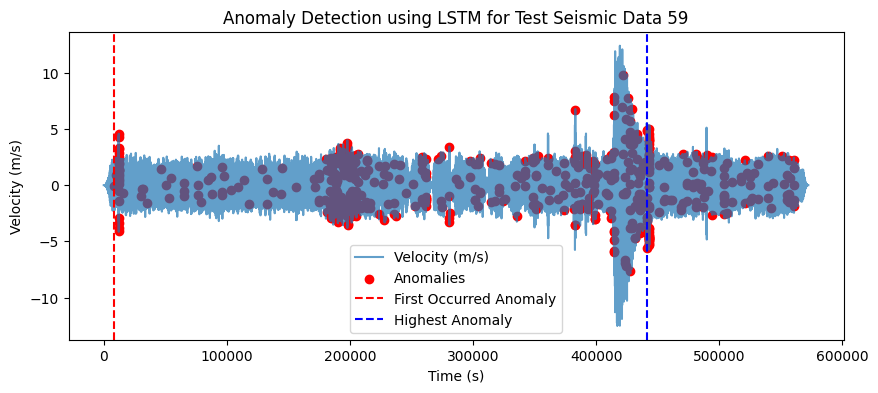

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


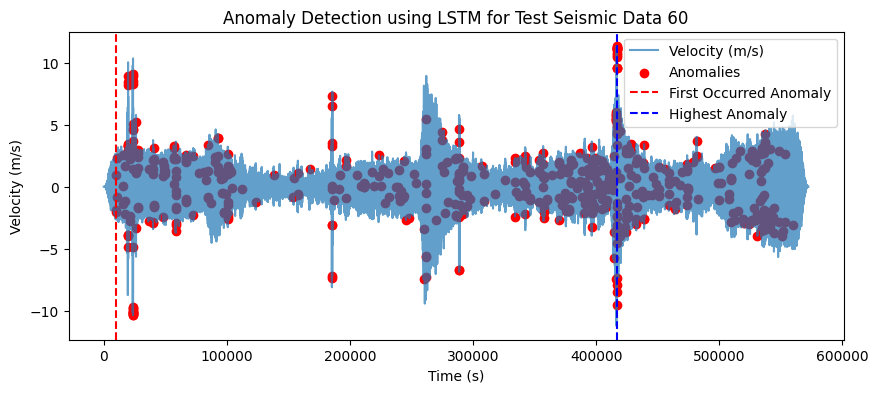

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


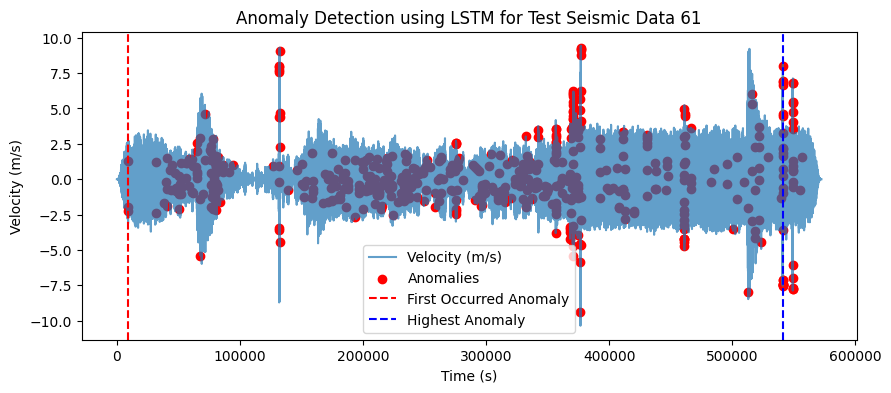

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step


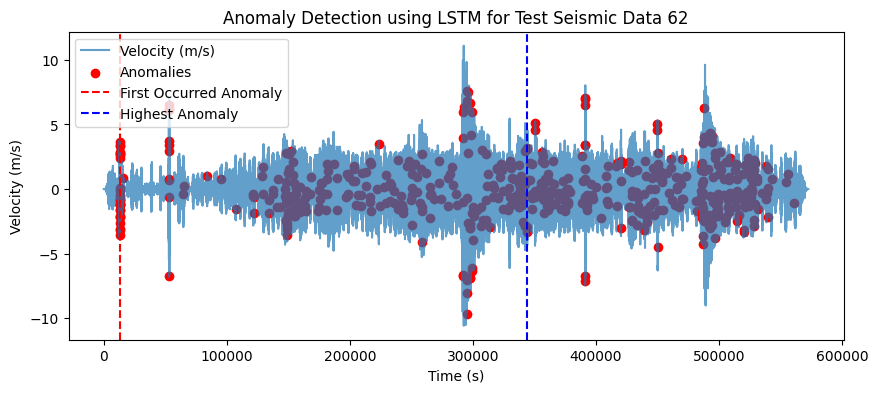

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


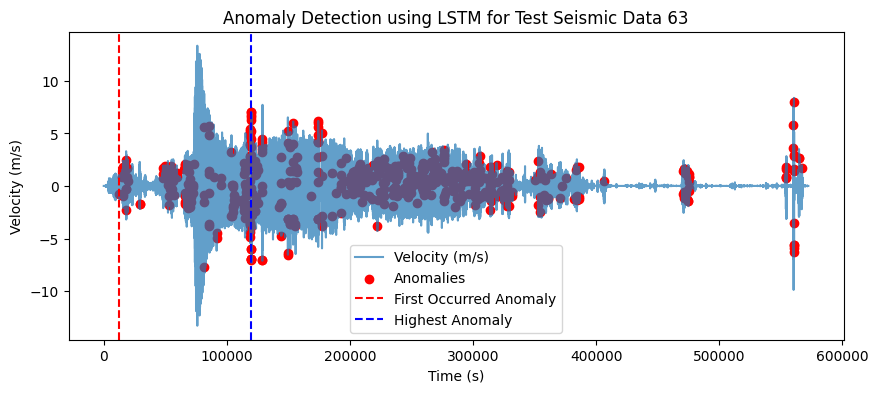

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


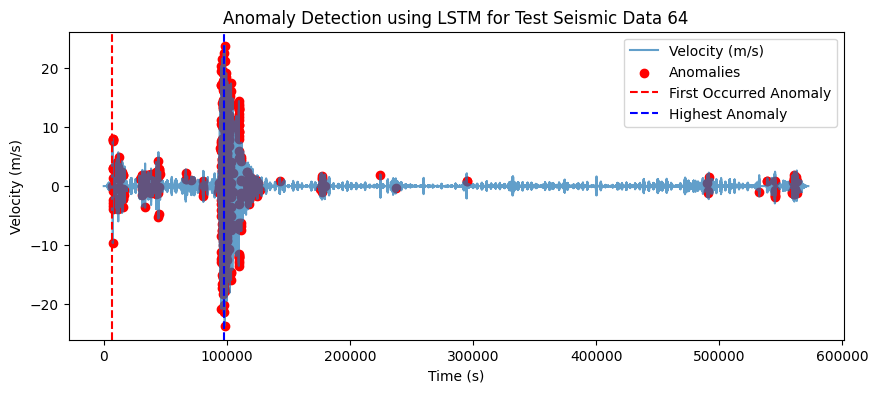

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


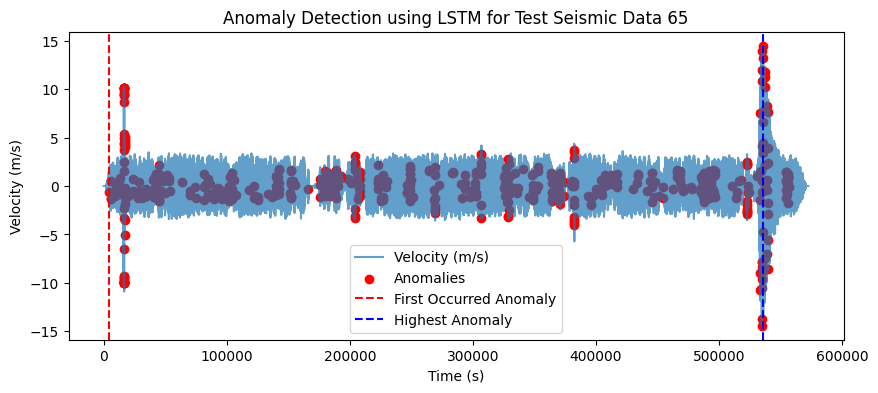

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


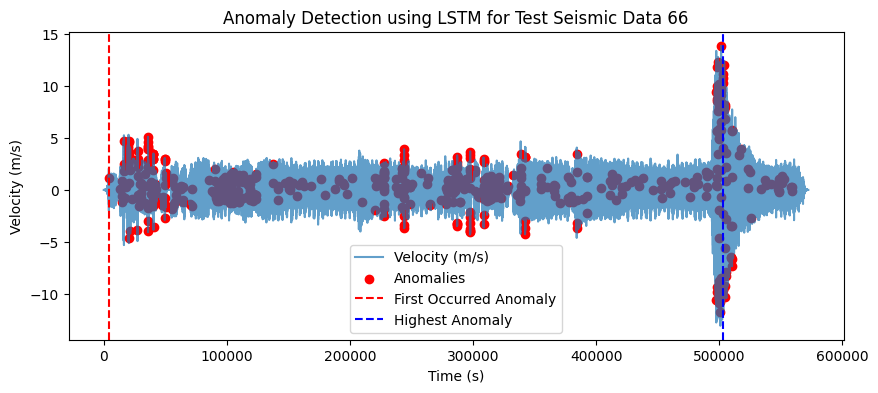

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


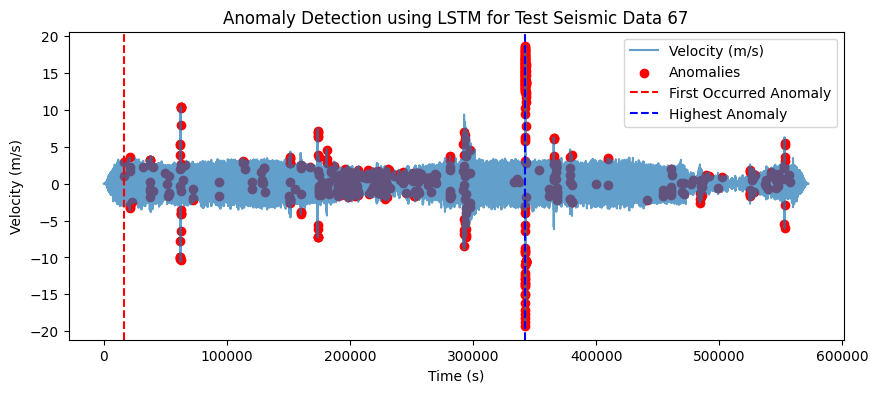

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


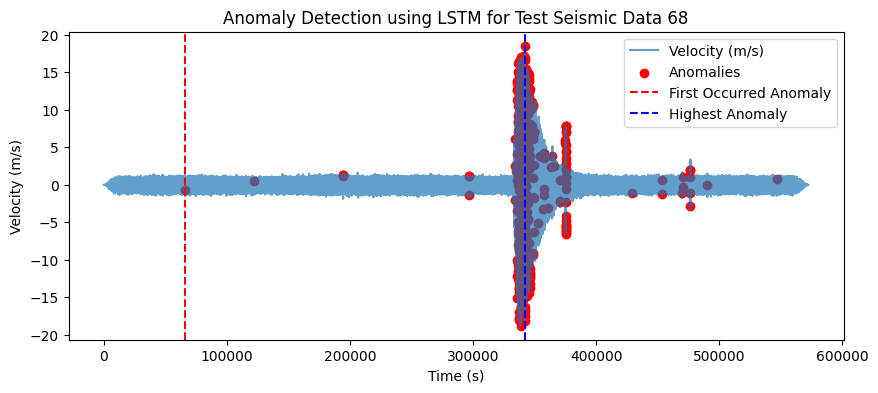

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


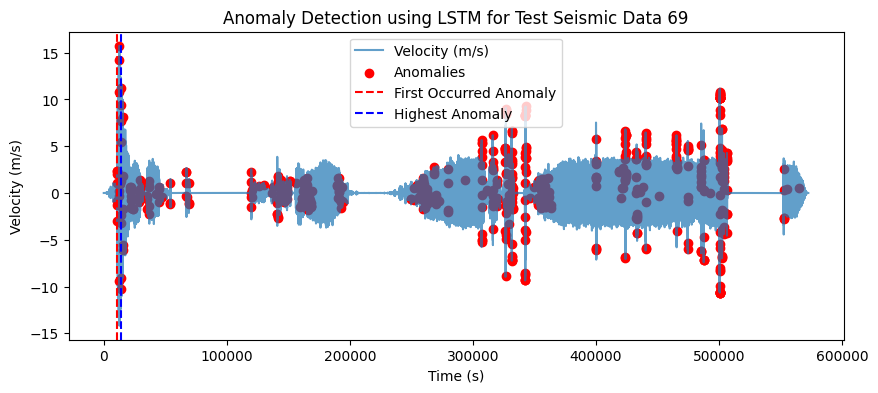

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


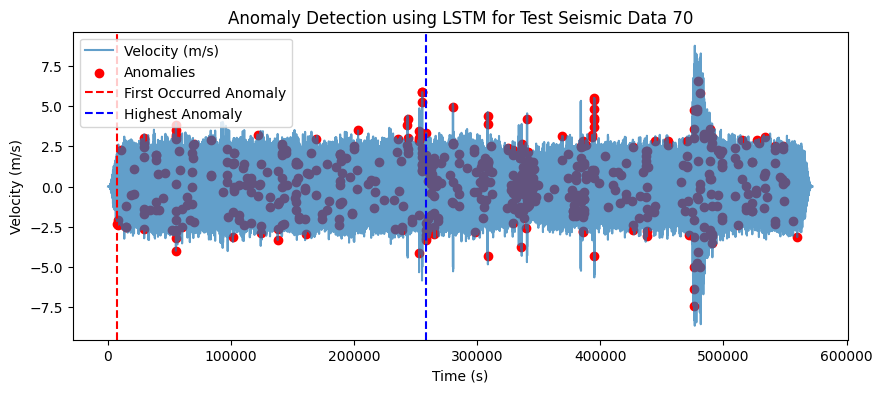

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


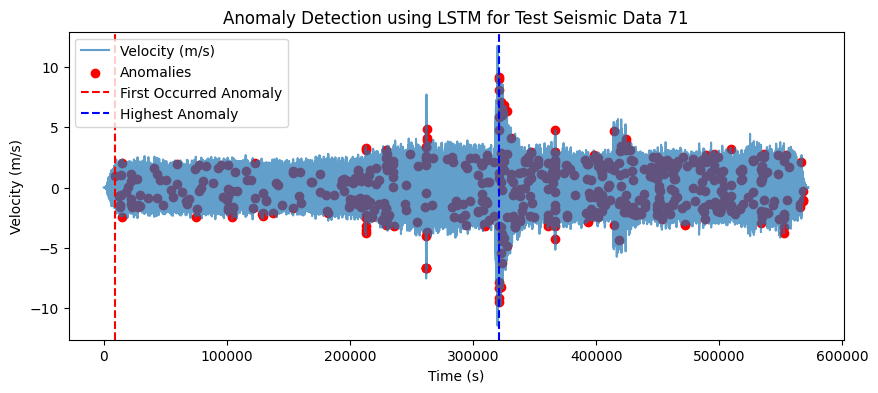

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


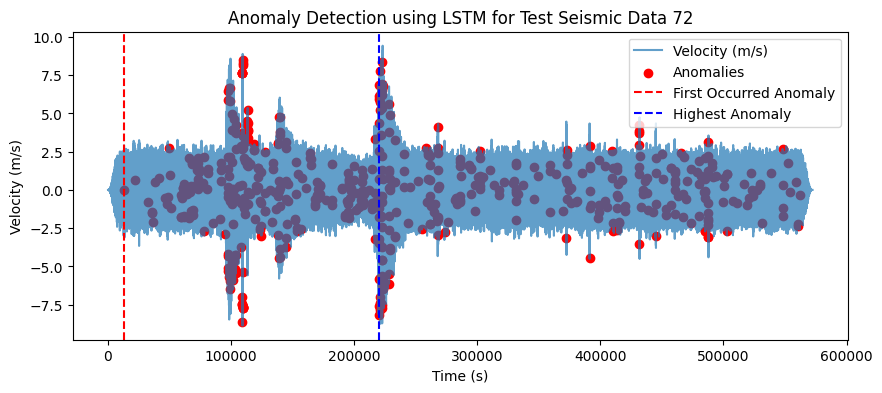

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


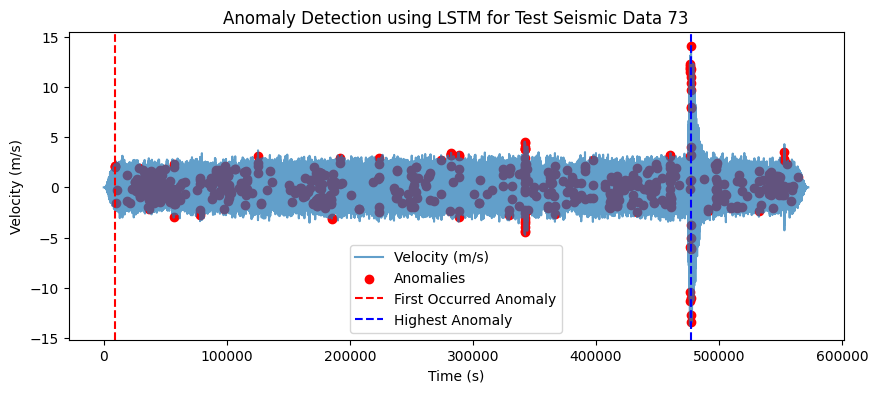

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step


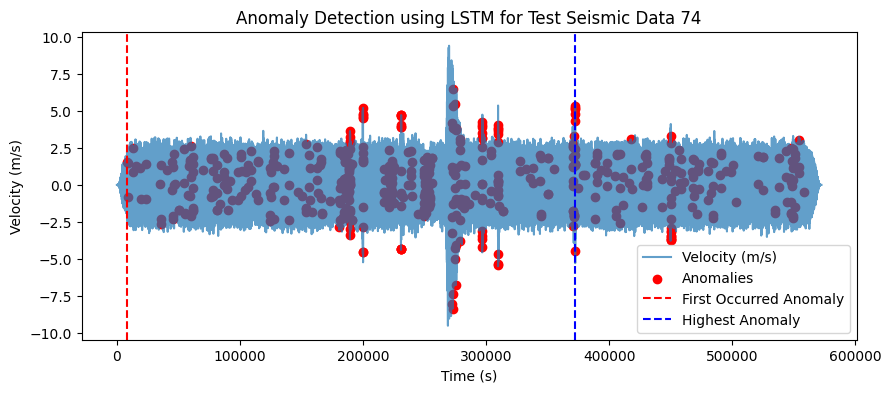

17145/17145 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step


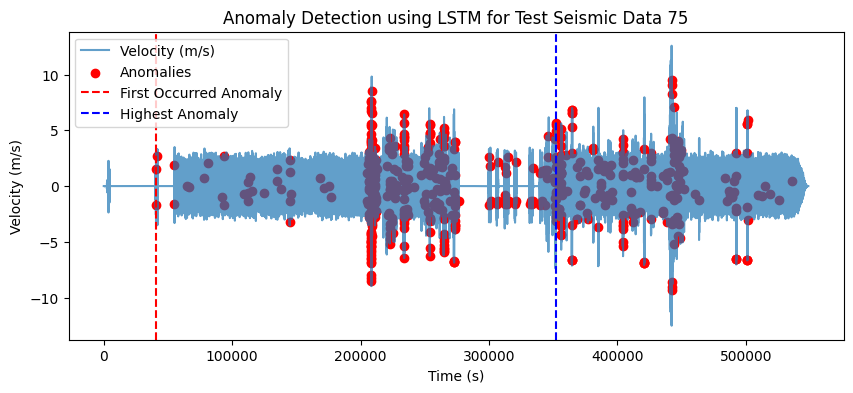

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


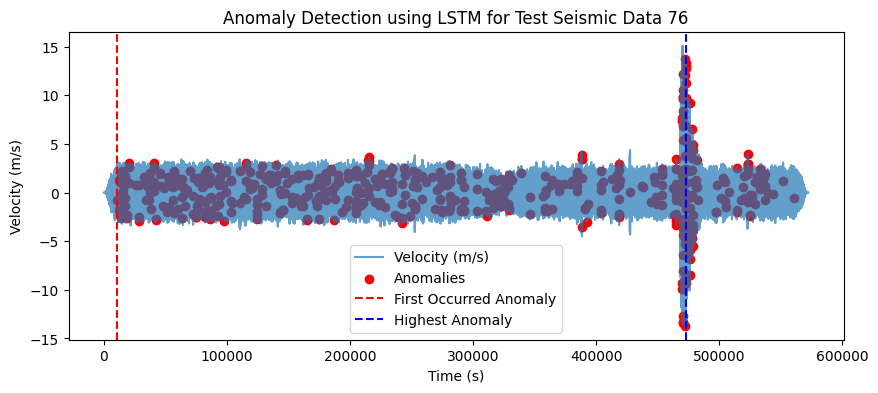

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


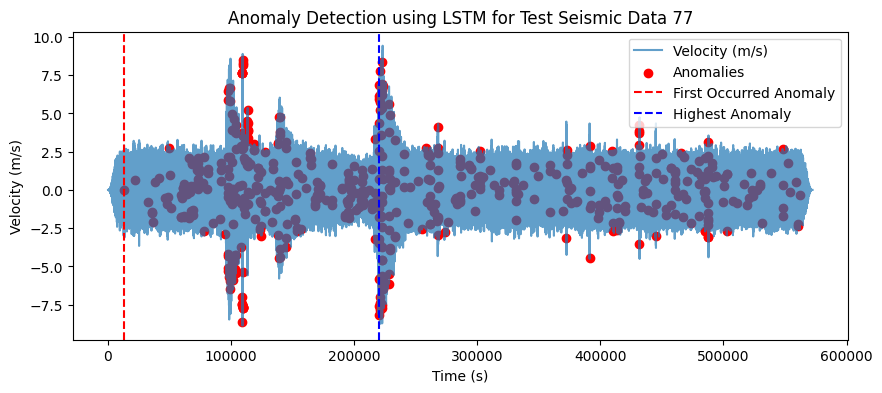

17886/17886 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


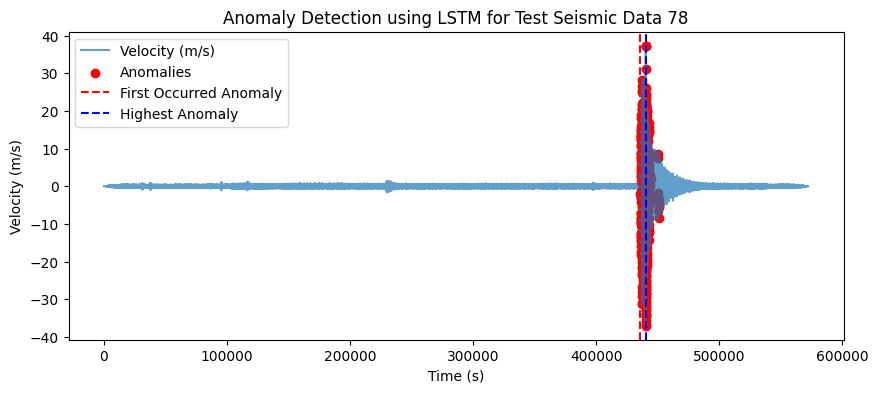

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step


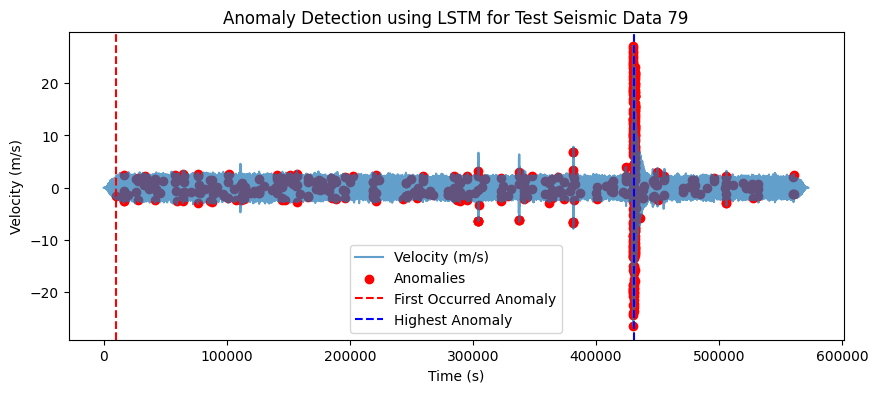

17162/17162 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step


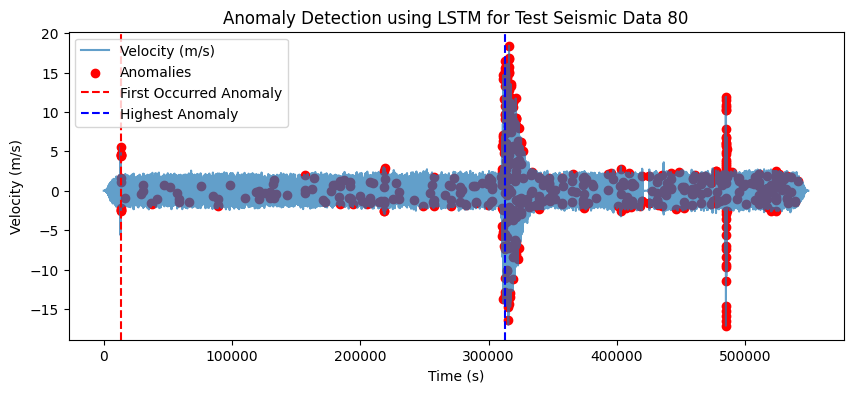

17888/17888 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


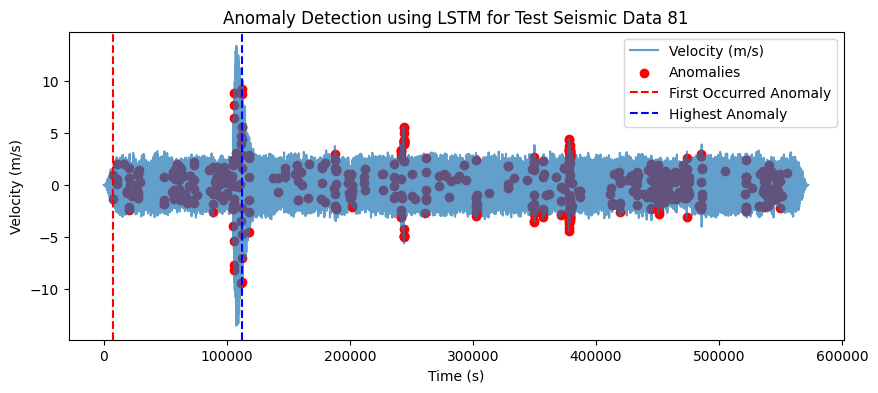

17882/17882 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


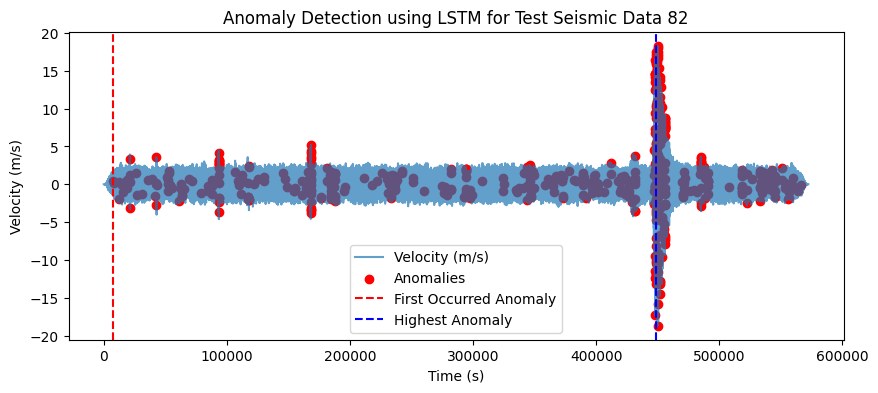

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


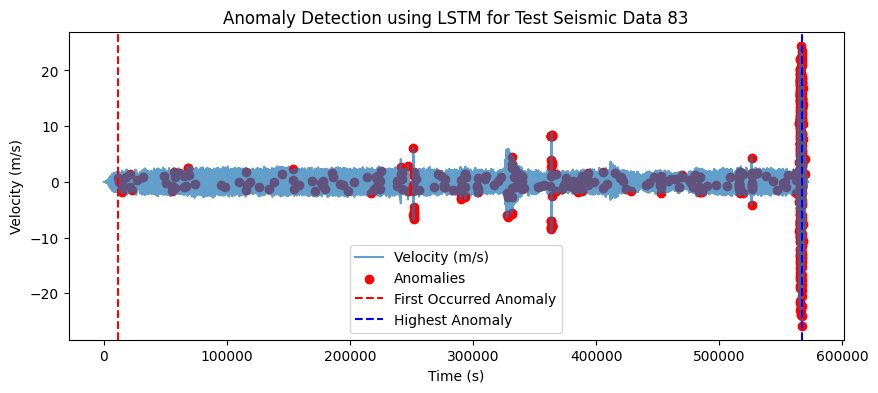

17887/17887 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


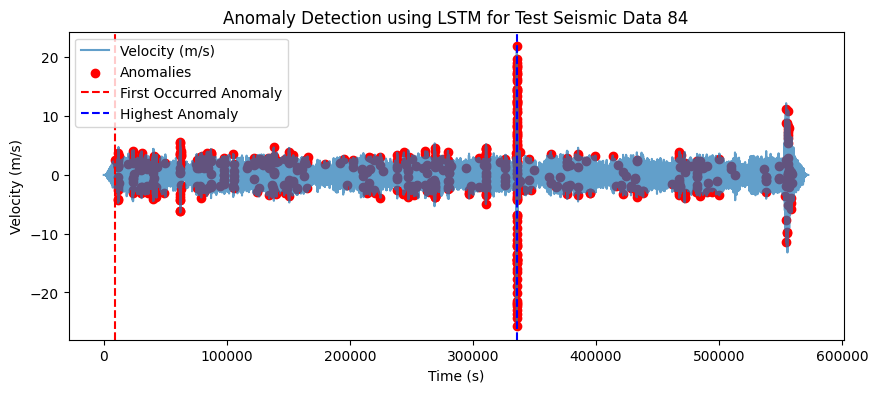

17888/17888 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step


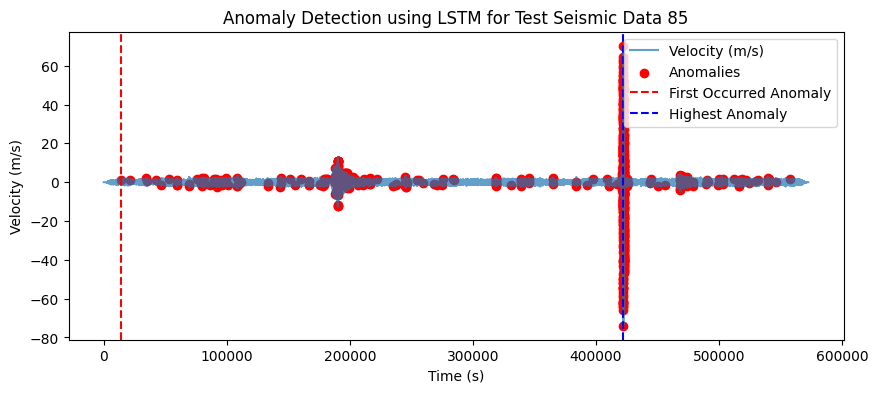

 2185/16205 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step

KeyboardInterrupt: 

In [ ]:
# Path to the test data directory
test_data_folder = '/content/space_apps_2024_seismic_detection/data/lunar/test/data/'

# List to hold test seismic data from all subfolders
test_seismic_data = []

# Iterate through all subfolders and files within the test data folder
for root, dirs, files in os.walk(test_data_folder):
    for file in files:
        if file.endswith('.mseed'):
            file_path = os.path.join(root, file)

            # Load seismic file using obspy
            st = obspy.read(file_path)

            # Store the loaded data for testing
            test_seismic_data.append(st)


# List to hold results for DataFrame
results_list = []

# Testing Phase: Use the trained model to predict on the test data
for i, st in enumerate(test_seismic_data):  # Use the test data from the subfolders
    # Extract seismic waveform data as a numpy array for each test file
    test_data = np.array([tr.data for tr in st], dtype=np.float32).reshape(-1, 1)

    # Normalize the test data
    test_data = (test_data - np.mean(test_data)) / np.std(test_data)

    # Create sequences for test data
    X_test, y_test = create_dataset(test_data, time_step)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # Reshape for LSTM

    # Make predictions on the test data using the trained model
    predicted_test = lstm_model.predict(X_test)

    # Calculate reconstruction error
    reconstruction_error_test = np.abs(predicted_test.flatten() - y_test)

    # Set a threshold for anomaly detection in test data
    threshold_test = np.percentile(reconstruction_error_test, 99.9)
    anomalies_test = reconstruction_error_test > threshold_test

    # Create a DataFrame to hold results for the test file
    results_test_df = pd.DataFrame({
        'time_rel(sec)': np.arange(len(y_test)) + time_step + 1,
        'velocity(m/s)': test_data[time_step + 1:len(predicted_test) + time_step + 1, 0],
        'reconstruction_error': reconstruction_error_test,
        'is_anomaly': anomalies_test
    })

    # Get the first occurred anomaly in the test file
    first_anomaly_test = results_test_df[results_test_df['is_anomaly']].sort_values(by='time_rel(sec)').iloc[0]

    # Get the highest anomaly in the test file (based on reconstruction error)
    highest_anomaly_test = results_test_df[results_test_df['is_anomaly']].sort_values(by='reconstruction_error', ascending=False).iloc[0]

    # Plot the results for the test file
    plt.figure(figsize=(10, 4))
    plt.plot(results_test_df['time_rel(sec)'], results_test_df['velocity(m/s)'], label='Velocity (m/s)', alpha=0.7)
    plt.scatter(results_test_df['time_rel(sec)'][results_test_df['is_anomaly']],
                results_test_df['velocity(m/s)'][results_test_df['is_anomaly']], color='red', label='Anomalies')

    # Mark the first occurred anomaly with a vertical line
    plt.axvline(x=first_anomaly_test['time_rel(sec)'], color='r', linestyle='--', label='First Occurred Anomaly')

    # Mark the highest anomaly with a vertical line
    plt.axvline(x=highest_anomaly_test['time_rel(sec)'], color='b', linestyle='--', label='Highest Anomaly')

    # Customize plot
    plt.title(f'Anomaly Detection using LSTM for Test Seismic Data {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.legend()
    plt.show()

    # Get the file name from the path
    file_name = os.path.basename(test_seismic_data[i].__str__())

    # Append the file name and the time of the highest anomaly to results_list
    results_list.append({
        'file_name': file_name,
        'time_rel(sec)': highest_anomaly_test['time_rel(sec)']
    })

    # (The rest of your plotting and printing code remains unchanged)

# After processing all test files, create a DataFrame from the results_list
results_df = pd.DataFrame(results_list)

# Save the results DataFrame to a CSV file
results_df.to_csv('anomaly_detection_results.csv', index=False)

# Optionally, display the results DataFrame
print(results_df)


In [ ]:
# After processing all test files, create a DataFrame from the results_list
results_df = pd.DataFrame(results_list)

# Save the results DataFrame to a CSV file
results_df.to_csv('anomaly_detection_results.csv', index=False)

# Optionally, display the results DataFrame
print(results_df)

NameError: name 'pd' is not defined

In [ ]:
import os
import pandas as pd

def list_mseed_files_to_dataframe(directory):
    file_list = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.mseed'):
                file_list.append({'file_name': file})
    return pd.DataFrame(file_list)

# Example usage
test_data_folder = '/content/space_apps_2024_seismic_detection/data/lunar/test/data/'

df = list_mseed_files_to_dataframe(test_data_folder)
df

file_name
0   xa.s15.00.mhz.1974-08-04HR00_evid00557.mseed
1   xa.s15.00.mhz.1974-06-30HR00_evid00542.mseed
2   xa.s15.00.mhz.1975-05-20HR00_evid00653.mseed
3   xa.s15.00.mhz.1974-06-16HR00_evid00536.mseed
4   xa.s15.00.mhz.1974-02-06HR00_evid00497.mseed
..                                           ...
91  xa.s16.00.mhz.1974-05-19HR00_evid00146.mseed
92  xa.s16.00.mhz.1973-07-31HR00_evid00123.mseed
93  xa.s16.00.mhz.1973-12-18HR00_evid00487.mseed
94  xa.s16.00.mhz.1973-08-25HR00_evid00443.mseed
95  xa.s16.00.mhz.1974-11-14HR00_evid00587.mseed

[96 rows x 1 columns]

In [ ]:
df.to_csv('file_list.csv', index=False)

# <a> We couldn't continue till the end of the data because we ran out of resources and the instance on Google colab stopped

>LSTM ML architechture is the best for signal processing and it perfectly fits our use case of seismic detection...
by increasing the epochs number and the batch size, it will take high resources and long time to train our model, but it will give way great results and hence, it's a great solution for our problem.  